## 1. General Clustering Algorithms applied to the PCA-reduced-flattened-CTM-space

(a bit of a mouthful)

This will walkthrough the entire baseline clustering on the CTMs. Note that this is simply a notebook overview of the functions found in `scripts/ctms_general.py`

**NOTE**: You can find our own implementations of clustering algorithms in the `models/cluster.py` file. These were tested on a much smaller corpus, however run time duration and memory issues became apparent when scaling to the full dataset. With this in mind we default to sklearn's implementations in the notebook.

Baseline Clustering with CTMs

In [1]:
import os
os.chdir('..')

1. Let's load the dataset

In [2]:
from utils.load import load_ctms_dataset
ctms_df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")
ctms_df.head()

name  \
0  Star Wars: Rogue Squadron II - Rogue Leader   
1  Star Wars: Rogue Squadron II - Rogue Leader   
2                      Donkey Kong Jungle Beat   
3                      Donkey Kong Jungle Beat   
4                                Viewtiful Joe   

                                       note_sequence  \
0  [55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...   
1  [59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...   
2  [45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...   
3  [70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...   
4  [33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...   

                                                 ctm      id rating  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  341259      0   

                          themes  \
0  ["Action", "Science fiction"]   
1  ["Action", "Science fiction"]   
2                     ["Action"]   
3                     ["Action"]   
4                     ["Action"]   

                                            keywords  \
0  ["space simulation", "space combat", "robots",...   
1  ["space simulation", "space combat", "robots",...   
2  ["combat", "pig", "panda", "underwater gamepla...   
3  ["combat", "pig", "panda", "underwater gamepla...   
4                                                 []   

                                  involved_companies first_release_year  \
0            ["Activision", "Factor 5", "LucasArts"]               2001   
1            ["Activision", "Factor 5", "LucasArts"]               2001   
2  ["Nintendo EAD Tokyo Software Development Grou...               2004   
3  ["Nintendo EAD Tokyo Software Development Grou...               2004   
4                        ["Clover Studio", "Capcom"]               2004   

                                            metadata  
0  star wars rogue squadron ii rogue leader actio...  
1  star wars rogue squadron ii rogue leader actio...  
2  donkey kong jungle beat action combat pig pand...  
3  donkey kong jungle beat action combat pig pand...  
4          viewtiful joe action clover studio capcom

We need to preprocess. This involves: Converting ctm (currently nested lists) into 129x129 matrix -> Flatten -> Perform PCA to reduce dimensionality (also use mahalanobis distance thresholding).

In [3]:
from scripts.ctms_general import preprocess_ctms
preprocessed_ctms_df, X_pca = preprocess_ctms(ctms_df, n_components=30) 
X_pca.shape

2025-12-04 11:47:26.551 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 920 dims (≥90% variance)
2025-12-04 11:47:27.927 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 74 outliers (Mahalanobis, χ² threshold=59.70)


(3246, 30)

We've reduced the number of dimensions down to 30. Naturally, this has resulted in quite a bit of information loss. However, we feel that is crucial regardless. Retaining $\geq 90\%$ variance would require keeping 904 dimensions.

Now we proceed with cluster tuning based on davies bouldin and silhouette

#### Tuning $K$ via Silhouette Score

In [4]:
from scripts.ctms_general import tune_clusters

tuning_results = tune_clusters(
    preprocessed_ctms_df,
    k_list=list(range(2, 21)),
    n_components=30,
    save = False
)
tuning_results

2025-12-04 11:47:28.032 | INFO     | scripts.ctms_general:tune_clusters:129 - Preprocessing CTMs...
2025-12-04 11:48:07.728 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-04 11:48:08.767 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 130 outliers (Mahalanobis, χ² threshold=59.70)
Tuning KMeans: 100%|██████████| 19/19 [00:06<00:00,  2.81it/s]


({'kmeans': {2: 0.41567984139085895,
   3: 0.41674026903645084,
   4: 0.409700801707908,
   5: 0.3197123798318374,
   6: 0.28962522828971643,
   7: 0.28200491158139773,
   8: 0.26946009800808945,
   9: 0.25011377172800614,
   10: 0.2720226744331211,
   11: 0.23591713062282674,
   12: 0.23114861505920248,
   13: 0.23257862028633208,
   14: 0.23556326530918398,
   15: 0.22495245586465706,
   16: 0.20696965195886477,
   17: 0.1986747603678121,
   18: 0.2039377266866419,
   19: 0.19887976260775453,
   20: 0.18634733812887236},
  'dbscan': {},
  'hierarchical': {}},
 {'kmeans': {2: 1.9220128283305313,
   3: 1.9207629711652998,
   4: 1.9017091698885835,
   5: 1.8363758747767,
   6: 1.8615276003624295,
   7: 1.780676823711587,
   8: 1.7861146125601999,
   9: 1.7500197991764646,
   10: 1.7925940538287013,
   11: 1.8207482984017722,
   12: 1.8370934221667603,
   13: 1.8800228606429175,
   14: 1.9174578415796872,
   15: 1.8564637350137154,
   16: 1.8542765791284834,
   17: 1.9038591129120845,
  

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- Figure ---
    "figure.figsize": (6, 4),
    "figure.dpi": 300,

    # --- Fonts ---
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif",       # or "sans-serif"
    "mathtext.fontset": "stix",   # clean math font

    # --- Axes ---
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.grid": False,

    # --- Ticks ---
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,

    # --- Legend ---
    "legend.fontsize": 10,
    "legend.frameon": False,

    # --- Colors / Colormap ---
    "image.cmap": "viridis",
})

plot the tuning results (from results)

In [6]:
import json
with open('results/ctms_general/json/ctm_tuning_scores.json', 'r') as f:
    tuning_results = json.load(f)
    
tuning_results

{'silhouette': {'kmeans': {'2': 0.49901745927628105,
   '3': 0.4779488235542436,
   '4': 0.4650267192720845,
   '5': 0.3503332158249229,
   '6': 0.36203184026406576,
   '7': 0.3547597568847556,
   '8': 0.3023987915449259,
   '9': 0.310902755045113,
   '10': 0.31268342082139283,
   '12': 0.2739557094404988,
   '15': 0.24650370085405868,
   '20': 0.2502384818544209,
   '25': 0.23527212132742312},
  'dbscan': {},
  'hierarchical': {}},
 'davies_bouldin': {'kmeans': {'2': 1.4829030178177645,
   '3': 1.5360256822949419,
   '4': 1.4316153582017377,
   '5': 1.4364433562651286,
   '6': 1.4305385275483677,
   '7': 1.326478982554455,
   '8': 1.4081285111185002,
   '9': 1.4143978938577115,
   '10': 1.3893598331489299,
   '12': 1.4249217928056757,
   '15': 1.480327257237362,
   '20': 1.4377661614878117,
   '25': 1.423604978467052},
  'dbscan': {},
  'hierarchical': {}}}

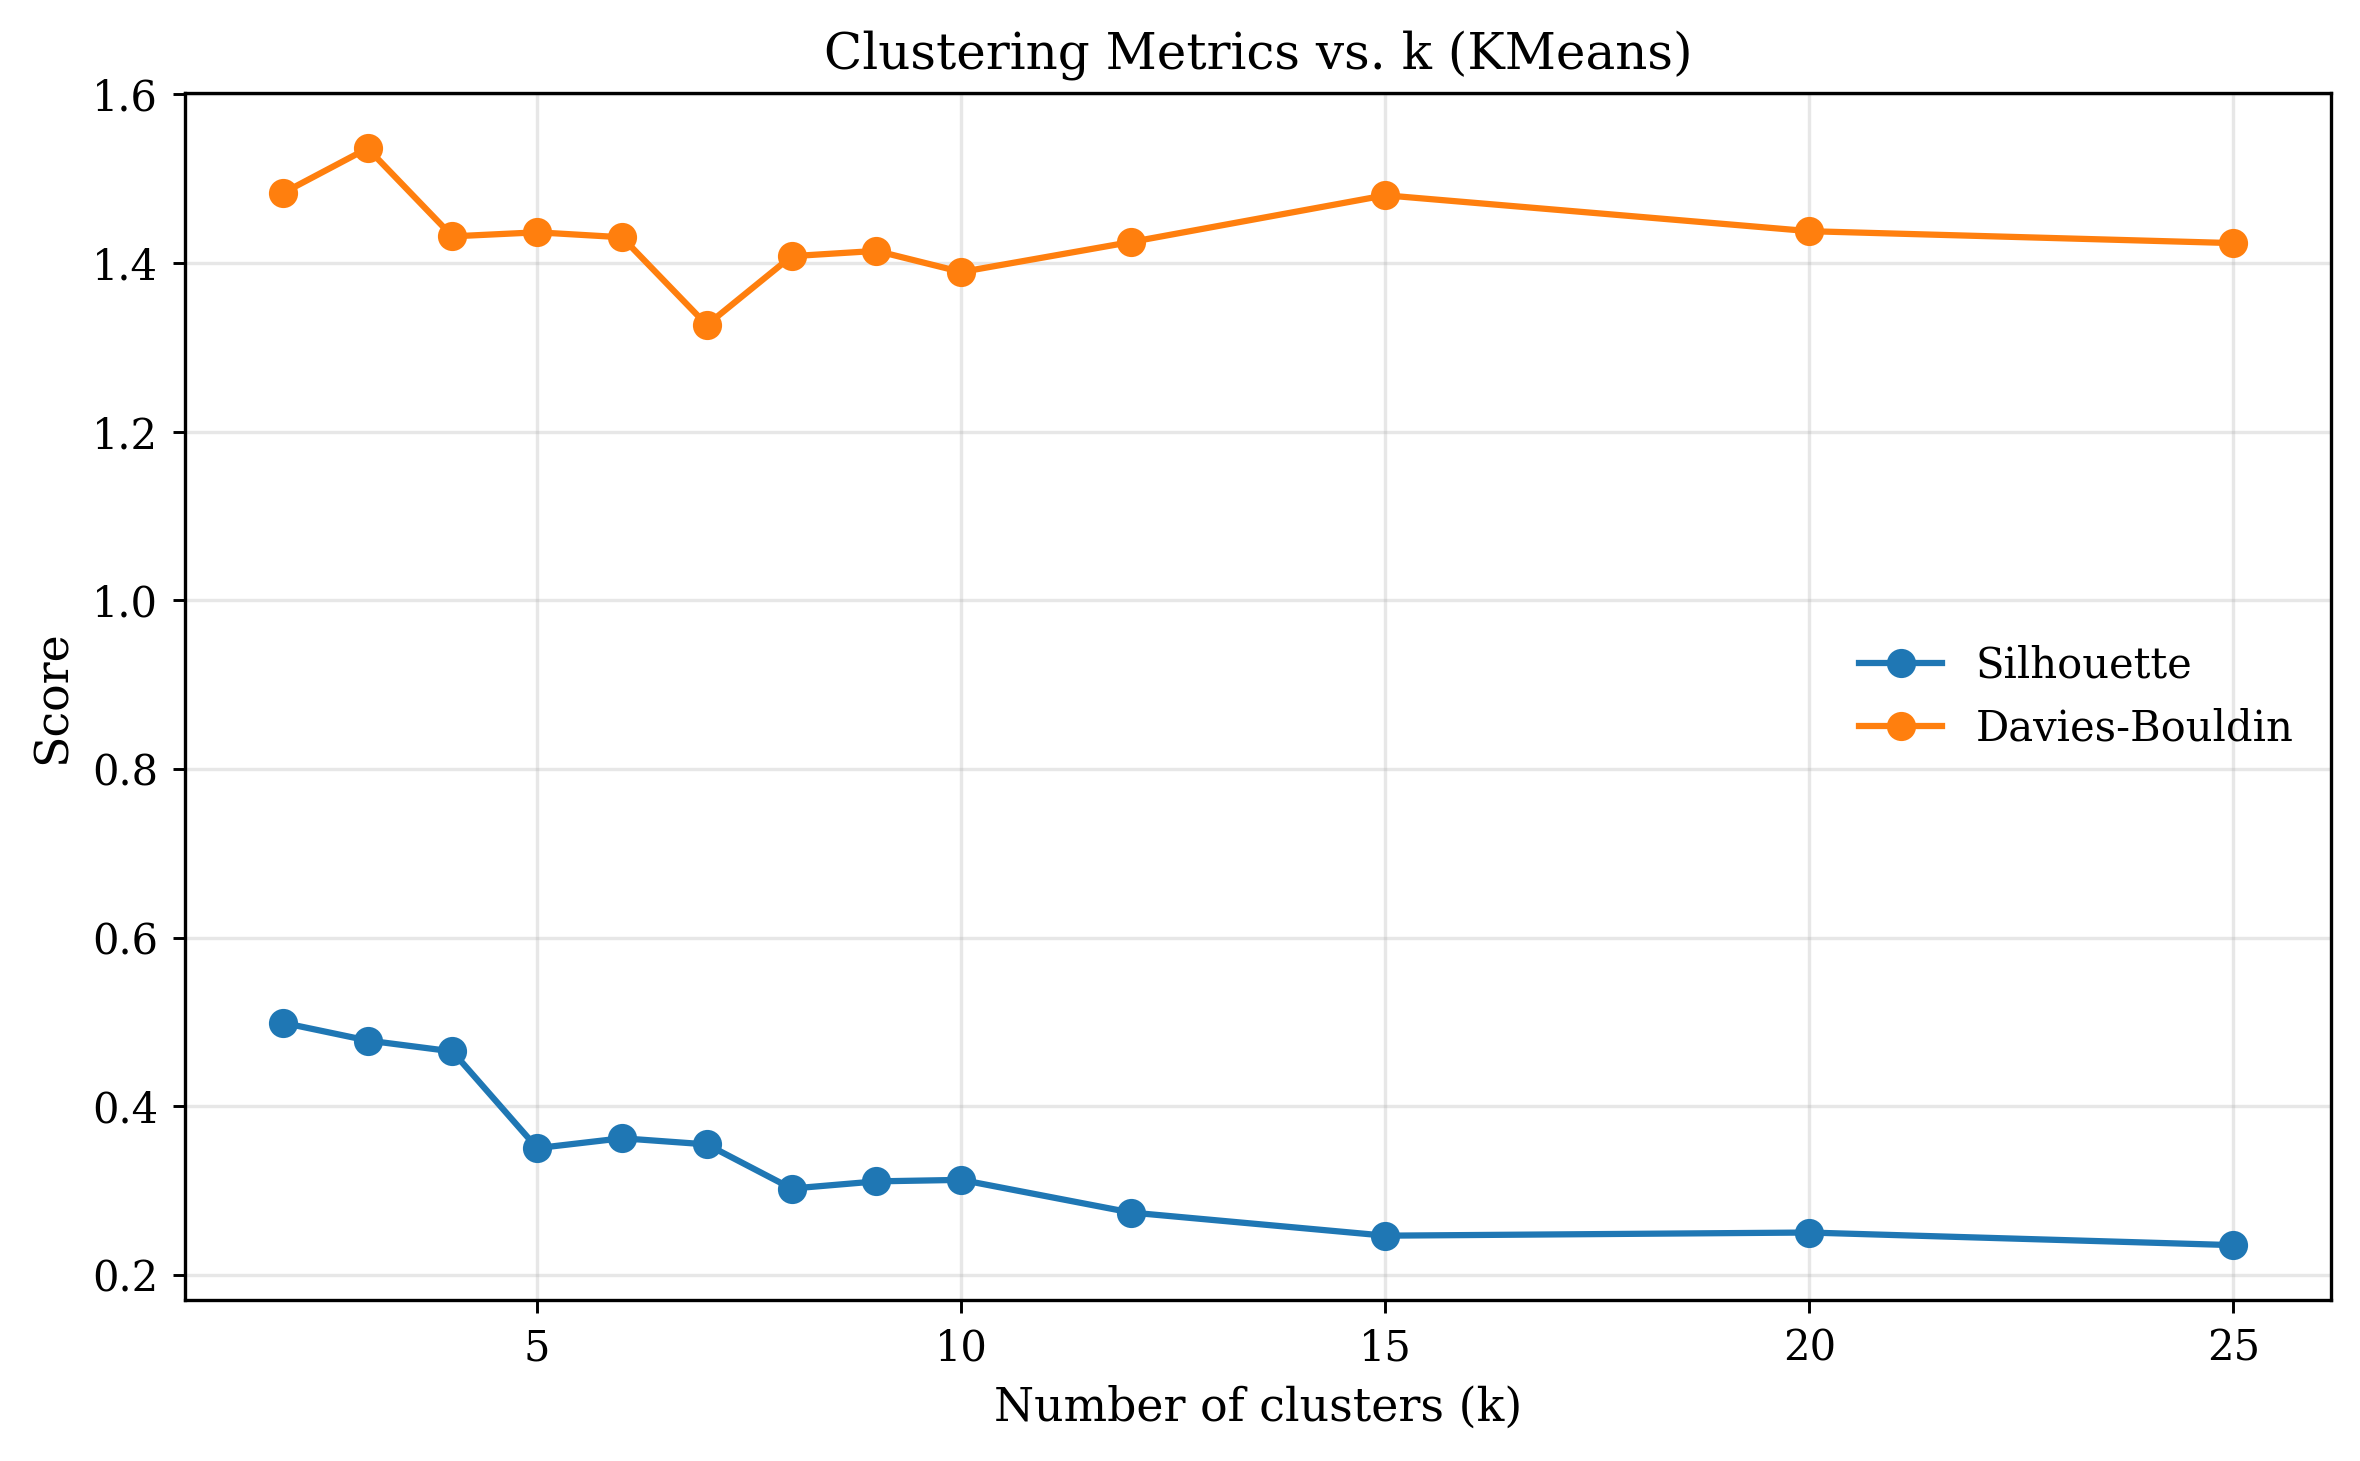

In [7]:
def plot_cluster_metrics(
    results: dict
):
    """
    Plot silhouette and Davies-Bouldin scores 

    Parameters
    ----------
    results : dict
    """
    silhouette_scores = results["silhouette"]["kmeans"]
    davies_bouldin_scores = results["davies_bouldin"]["kmeans"]

    # Convert keys to integers and sort
    ks_sil = sorted(int(k) for k in silhouette_scores.keys())
    vals_sil = [silhouette_scores[str(k)] for k in ks_sil]
    ks_db = sorted(int(k) for k in davies_bouldin_scores.keys())
    vals_db = [davies_bouldin_scores[str(k)] for k in ks_db]

    plt.figure(figsize=(8,5))

    plt.plot(ks_sil, vals_sil, marker="o", label="Silhouette")
    plt.plot(ks_db,  vals_db,  marker="o", label="Davies-Bouldin")

    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Score")
    plt.title("Clustering Metrics vs. k (KMeans)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_cluster_metrics(results=tuning_results)

Based on this, we select $k=6$

#### 2D, 3D Plot of Clusters

In [8]:
k=6

In [9]:
from scripts.ctms_general import plot_clusters

2025-12-04 11:49:53.645 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-04 11:49:56.375 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 129 outliers (Mahalanobis, χ² threshold=59.70)


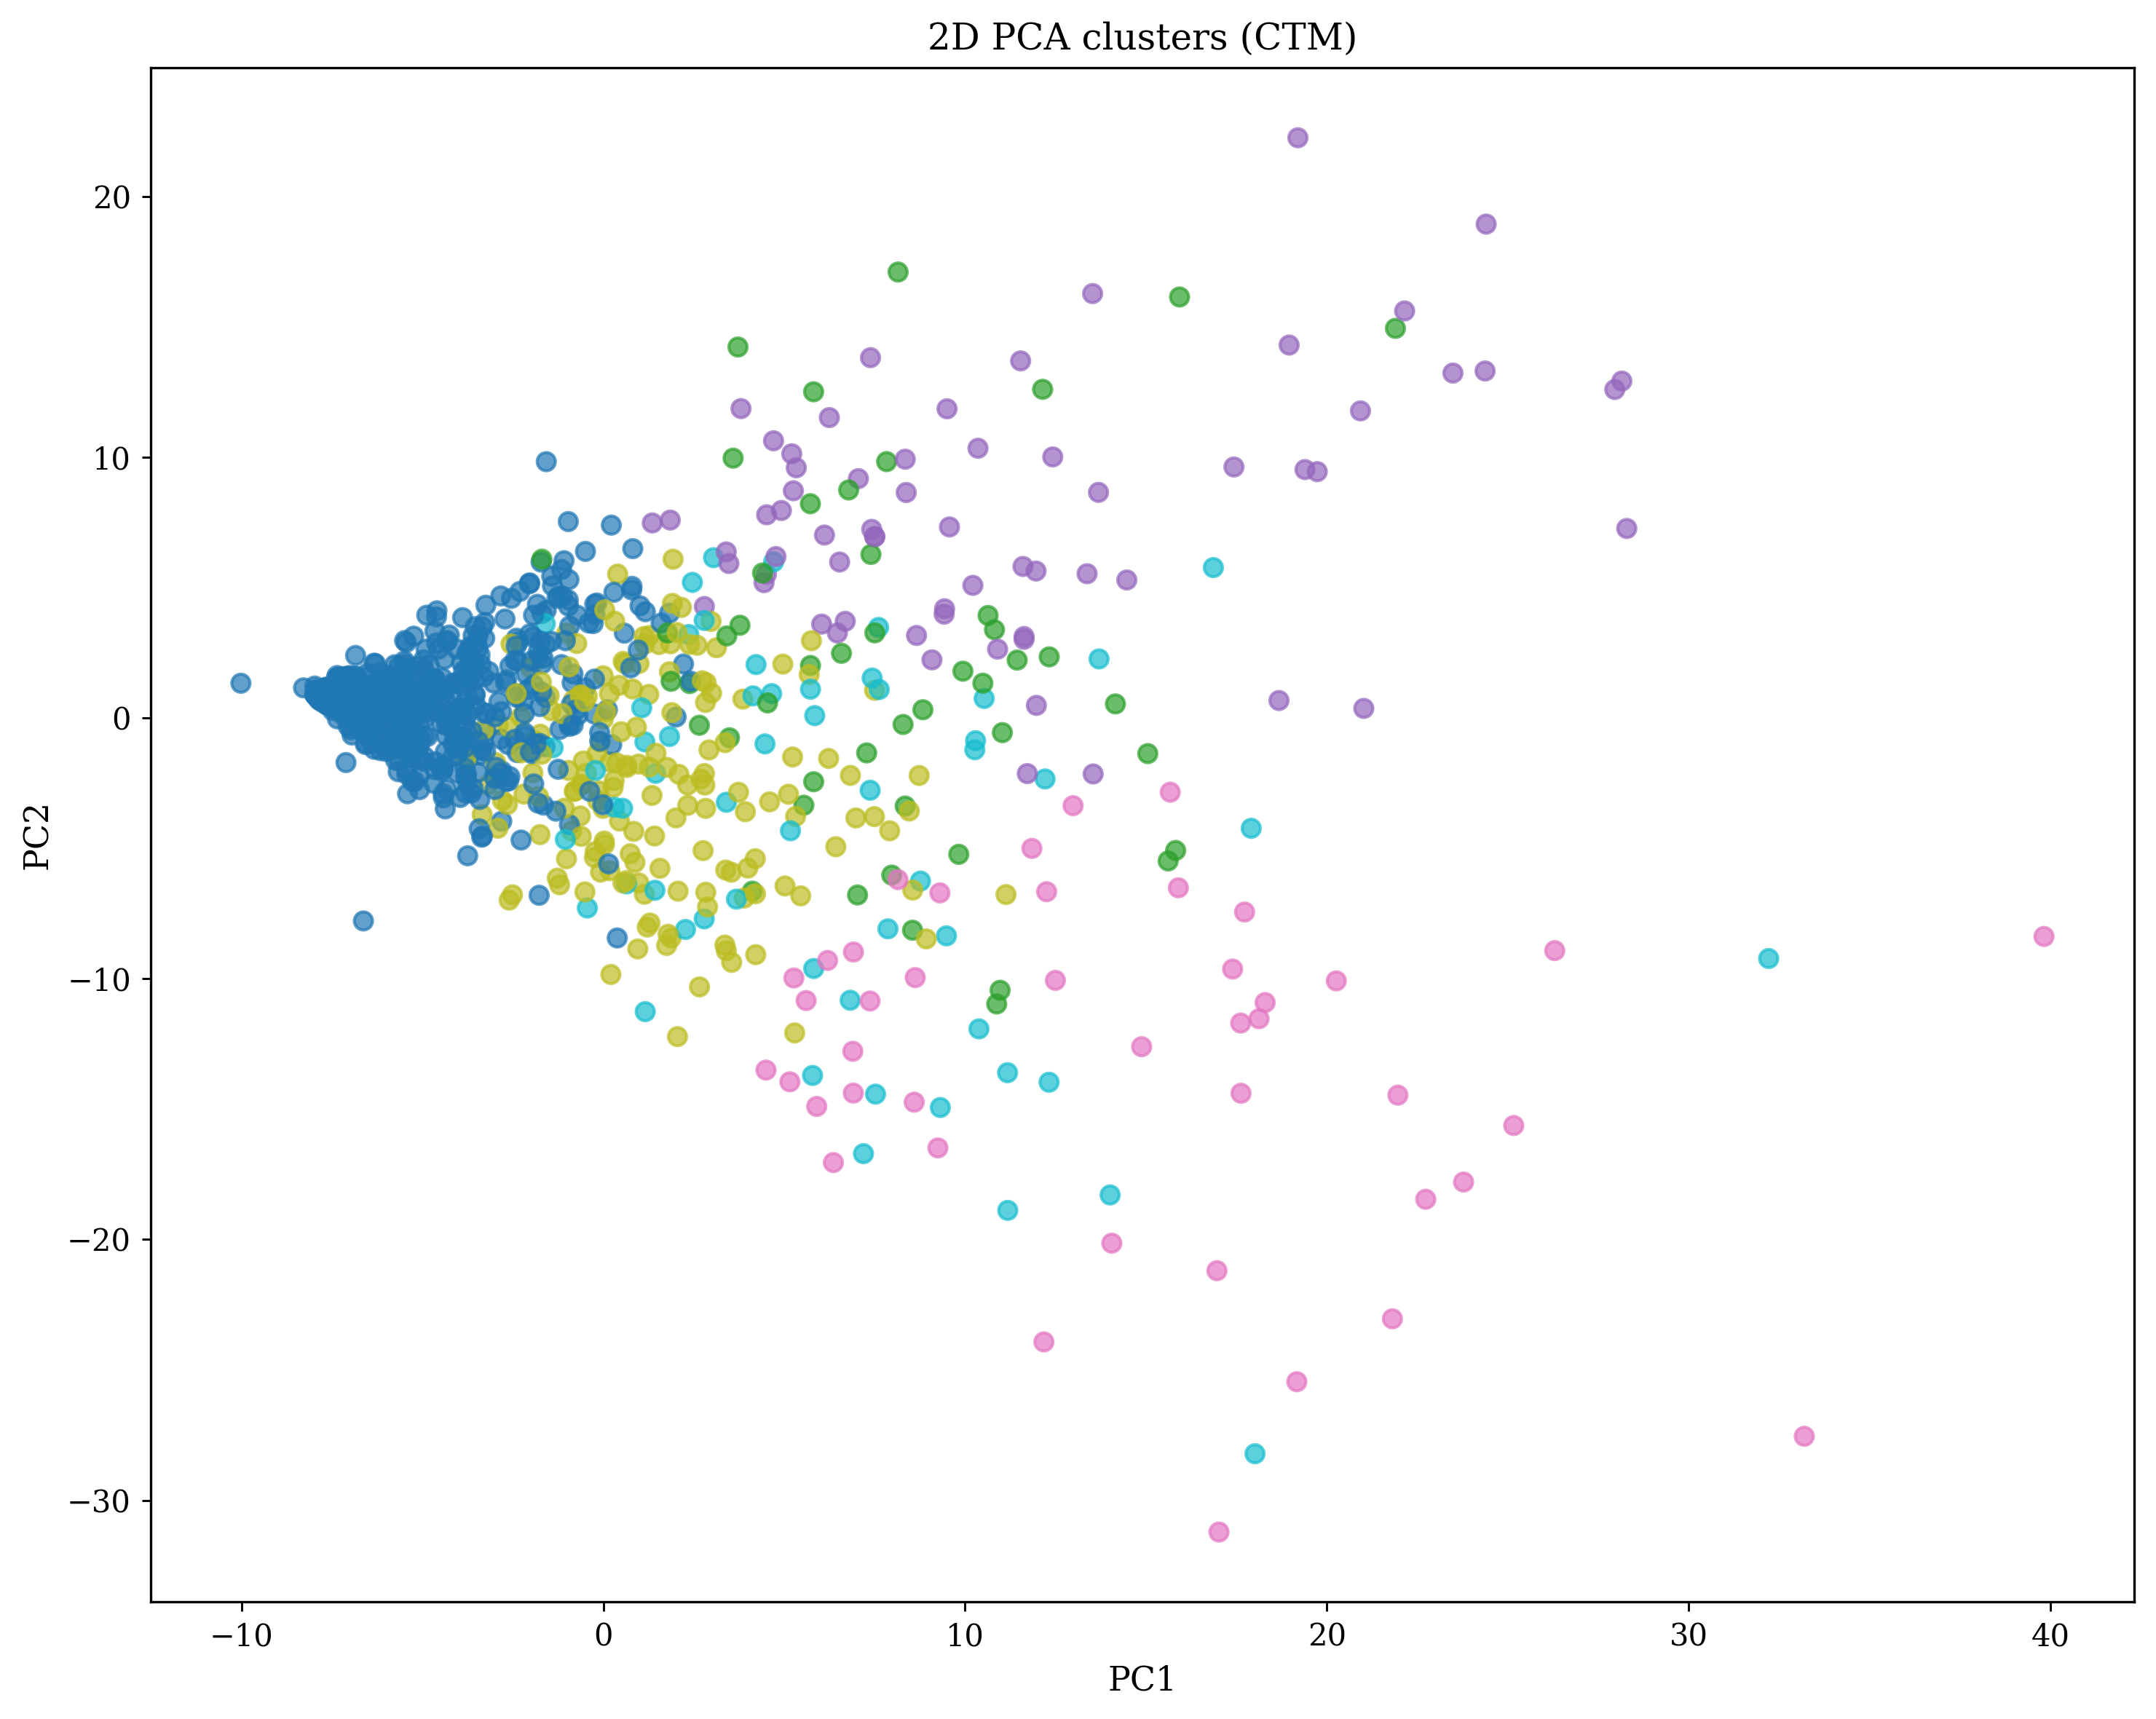

In [10]:
from sklearn.cluster import KMeans

_ = plot_clusters(
    preprocessed_ctms_df,
    n_components=30,
    model=KMeans(n_clusters=k, random_state=42),
    dim=2,
    save=False
)

2025-12-04 11:51:30.572 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-04 11:51:33.459 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 123 outliers (Mahalanobis, χ² threshold=59.70)


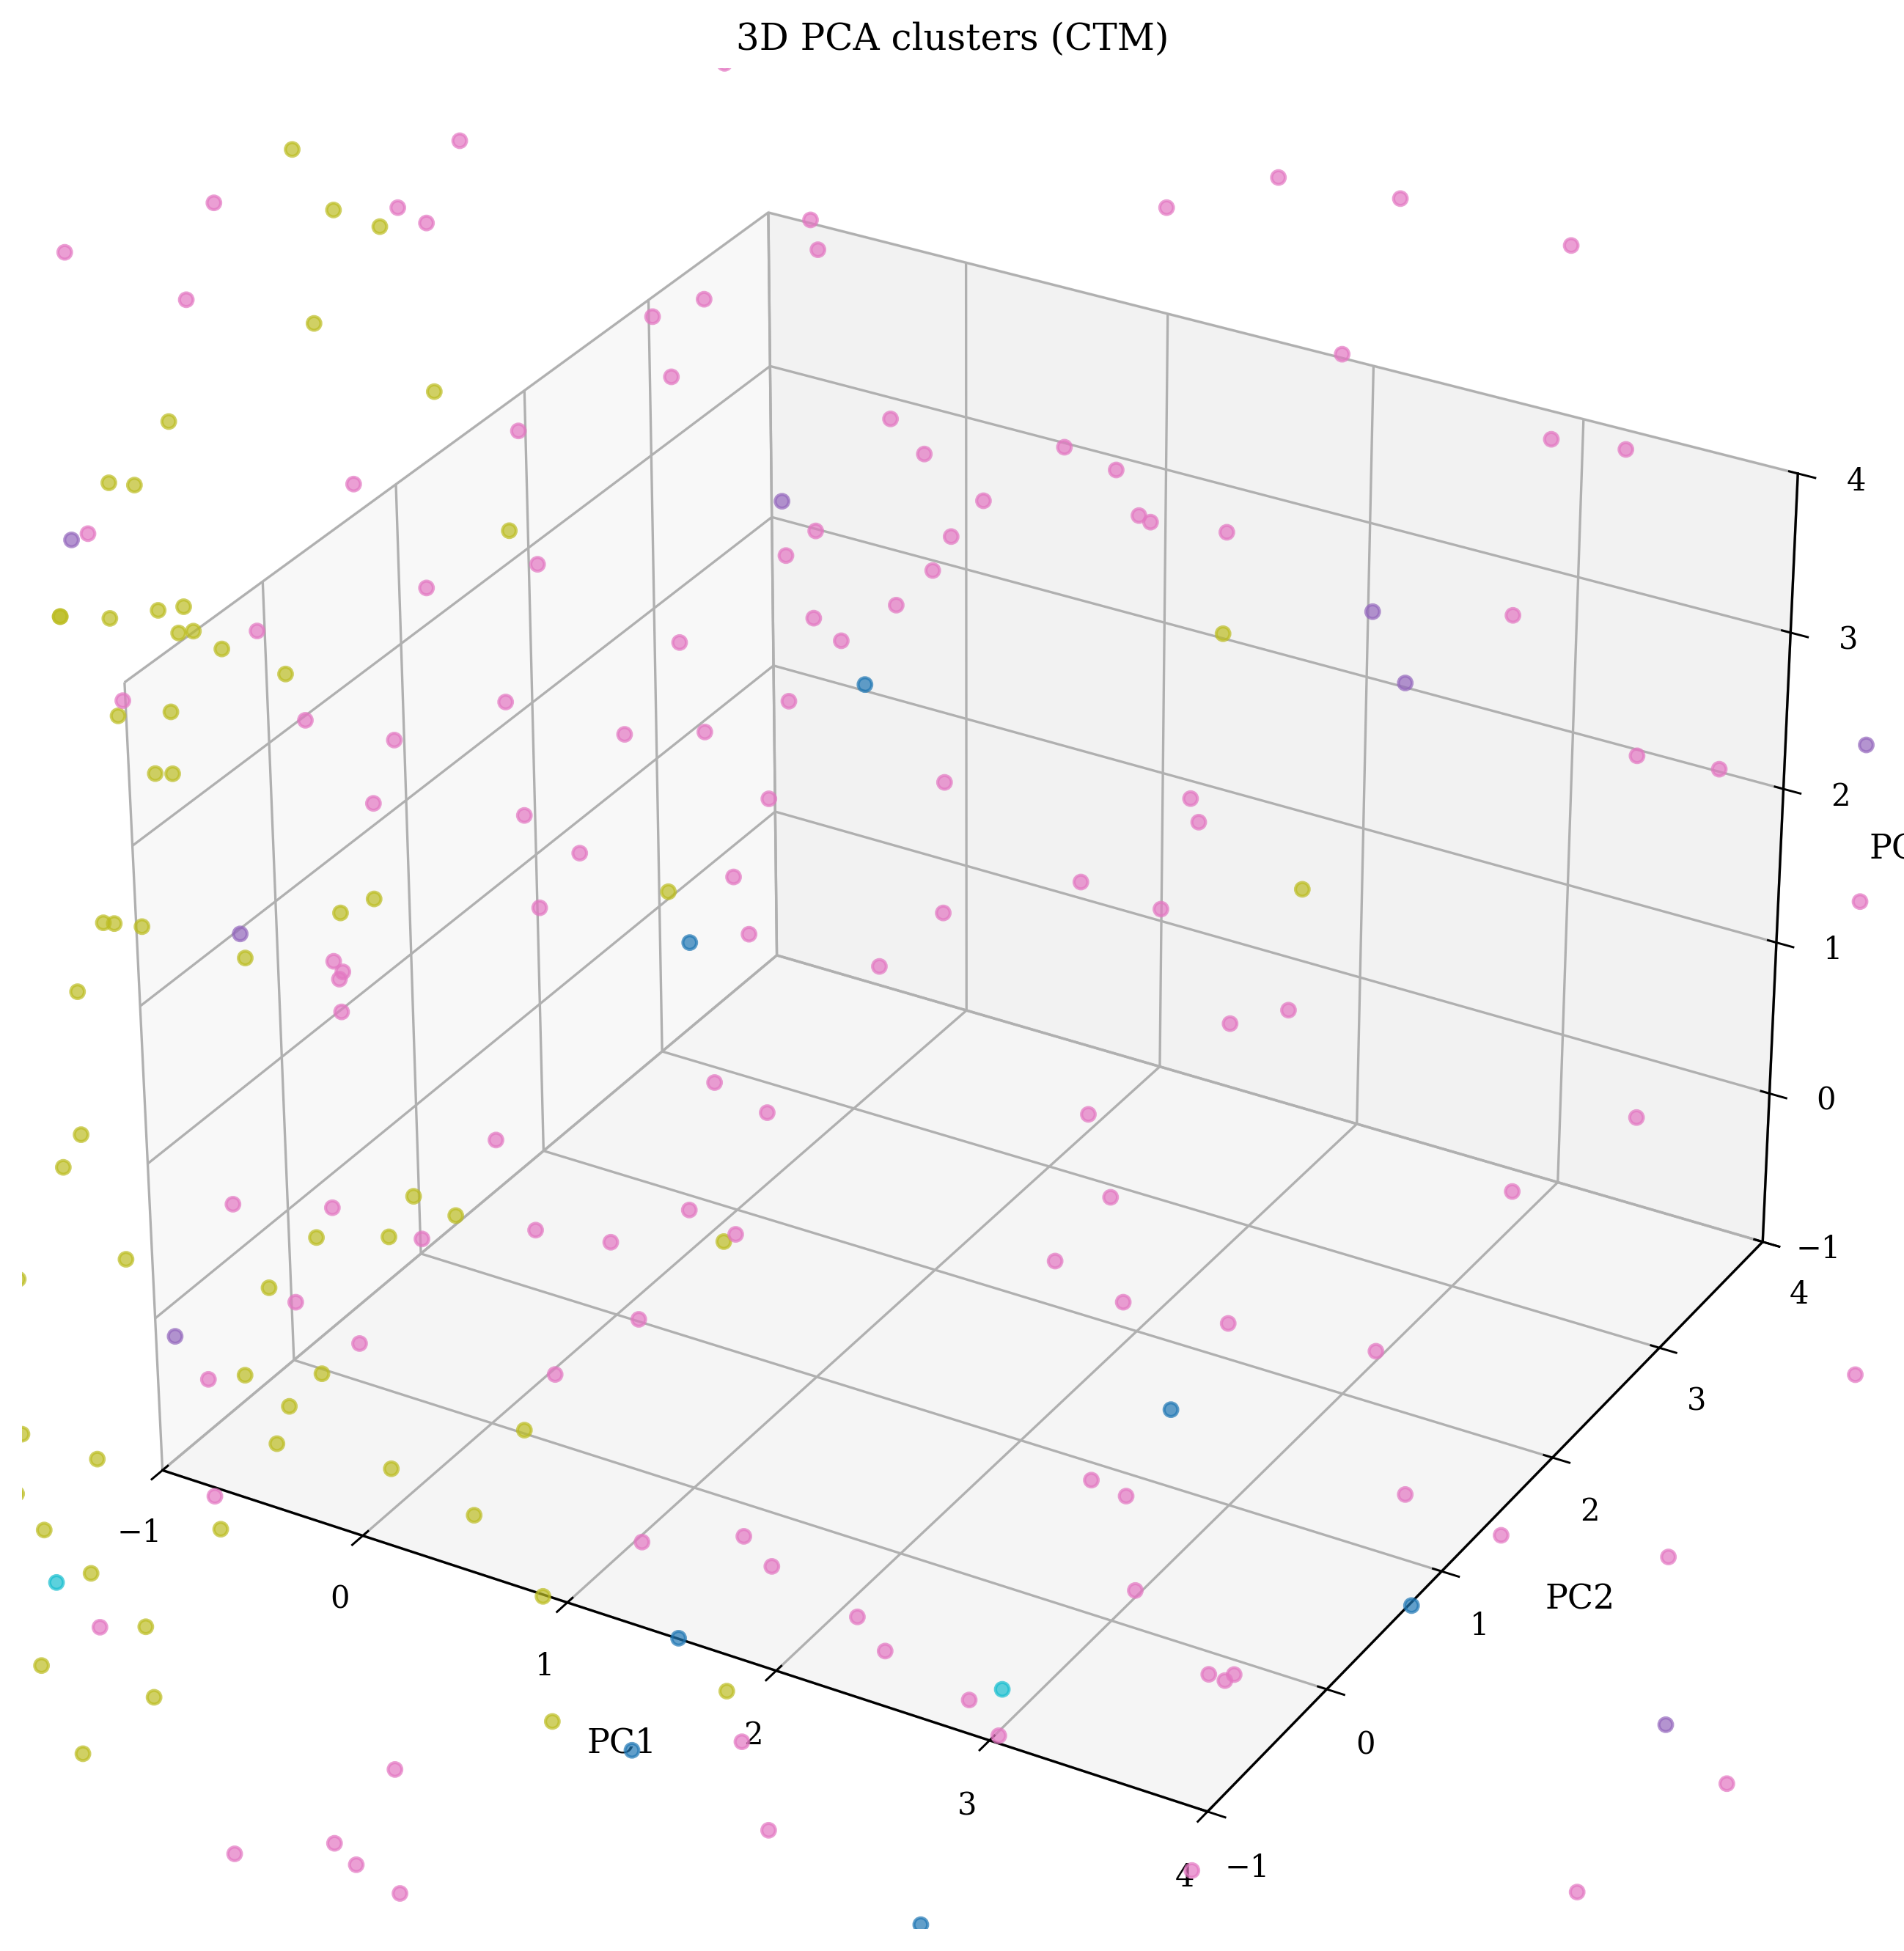

In [11]:
_ = plot_clusters(
    preprocessed_ctms_df,
    n_components=30,
    model=KMeans(n_clusters=k, random_state=42),
    dim=3,
    save=False
)

Visually not encouraging - expected from the CTM representation. Regardless, let's check out the clusters some more.

In [12]:
model = KMeans(n_clusters=k, random_state=42)
preprocessed_ctms_df['cluster_label'] = model.fit_predict(X_pca)


#### External Validation of Clusters

In [13]:
from utils.tf_idf import tfidf_cluster_summary

tf_idf = tfidf_cluster_summary(
    preprocessed_ctms_df
)
tf_idf

{0: ['zelda',
  'nintendo',
  'legend zelda',
  'legend',
  'ead software',
  'twilight princess',
  'fantasy zelda',
  'digitalscape',
  'nintendo imagica',
  'imagica digitalscape',
  'zelda twilight',
  'imagica',
  'zelda motion',
  'software development',
  'development group',
  'twilight',
  'group nintendo',
  'princess action',
  'group',
  'nintendo ead'],
 1: ['super',
  'crossover',
  'special',
  'hidden',
  'mascot',
  'hal',
  'laboratory',
  'hal laboratory',
  'attacks',
  'special attacks',
  'hidden character',
  'game console',
  'console fan',
  'sonic',
  'nintendo hal',
  'ness',
  'super ness',
  'pok',
  'mon',
  'legendary pok'],
 5: ['sonic',
  'distribution sega',
  'action digital',
  'adventure action',
  'sega sonic',
  'sonic adventure',
  'sonic team',
  'sega',
  'castlevania',
  'man',
  'mega man',
  'team',
  'mega',
  'horror konami',
  'mobile',
  'cast',
  'action cast',
  'disney mobile',
  'superscape',
  'superscape disney'],
 2: ['sonic',
  '

In [14]:
from utils.metrics import column_wise_summary

column_metrics = column_wise_summary(
    preprocessed_ctms_df,
    columns = ["name", "themes", "keywords", "involved_companies", "first_release_year"]
)

2025-12-04 11:51:35.748 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 0, column 'name'…
2025-12-04 11:51:35.797 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 0, column 'themes'…
2025-12-04 11:51:35.854 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 0, column 'keywords'…
2025-12-04 11:51:36.156 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 0, column 'involved_companies'…
2025-12-04 11:51:36.229 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 0, column 'first_release_year'…
2025-12-04 11:51:36.275 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 1, column 'name'…
2025-12-04 11:51:36.298 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 1, column 'themes'…
2025-12-04 11:51:36.318 | DEBUG    | utils.metrics:column_wise_summary:234 - Processing cluster 1, column 'keywords'…
2025-12-04 11:51:36.401 | DEBUG    | utils.metri

In [15]:
from utils.plot import plot_metadata_distributions

In [ ]:
# save_dir = "results/ctms_general/figs"
# model_name = "ctms"
save_dir = None
model_name = None



=== first_release_year ===
Figure saved to results/ctms_general/figs/ctms_first_release_year_distributions.png


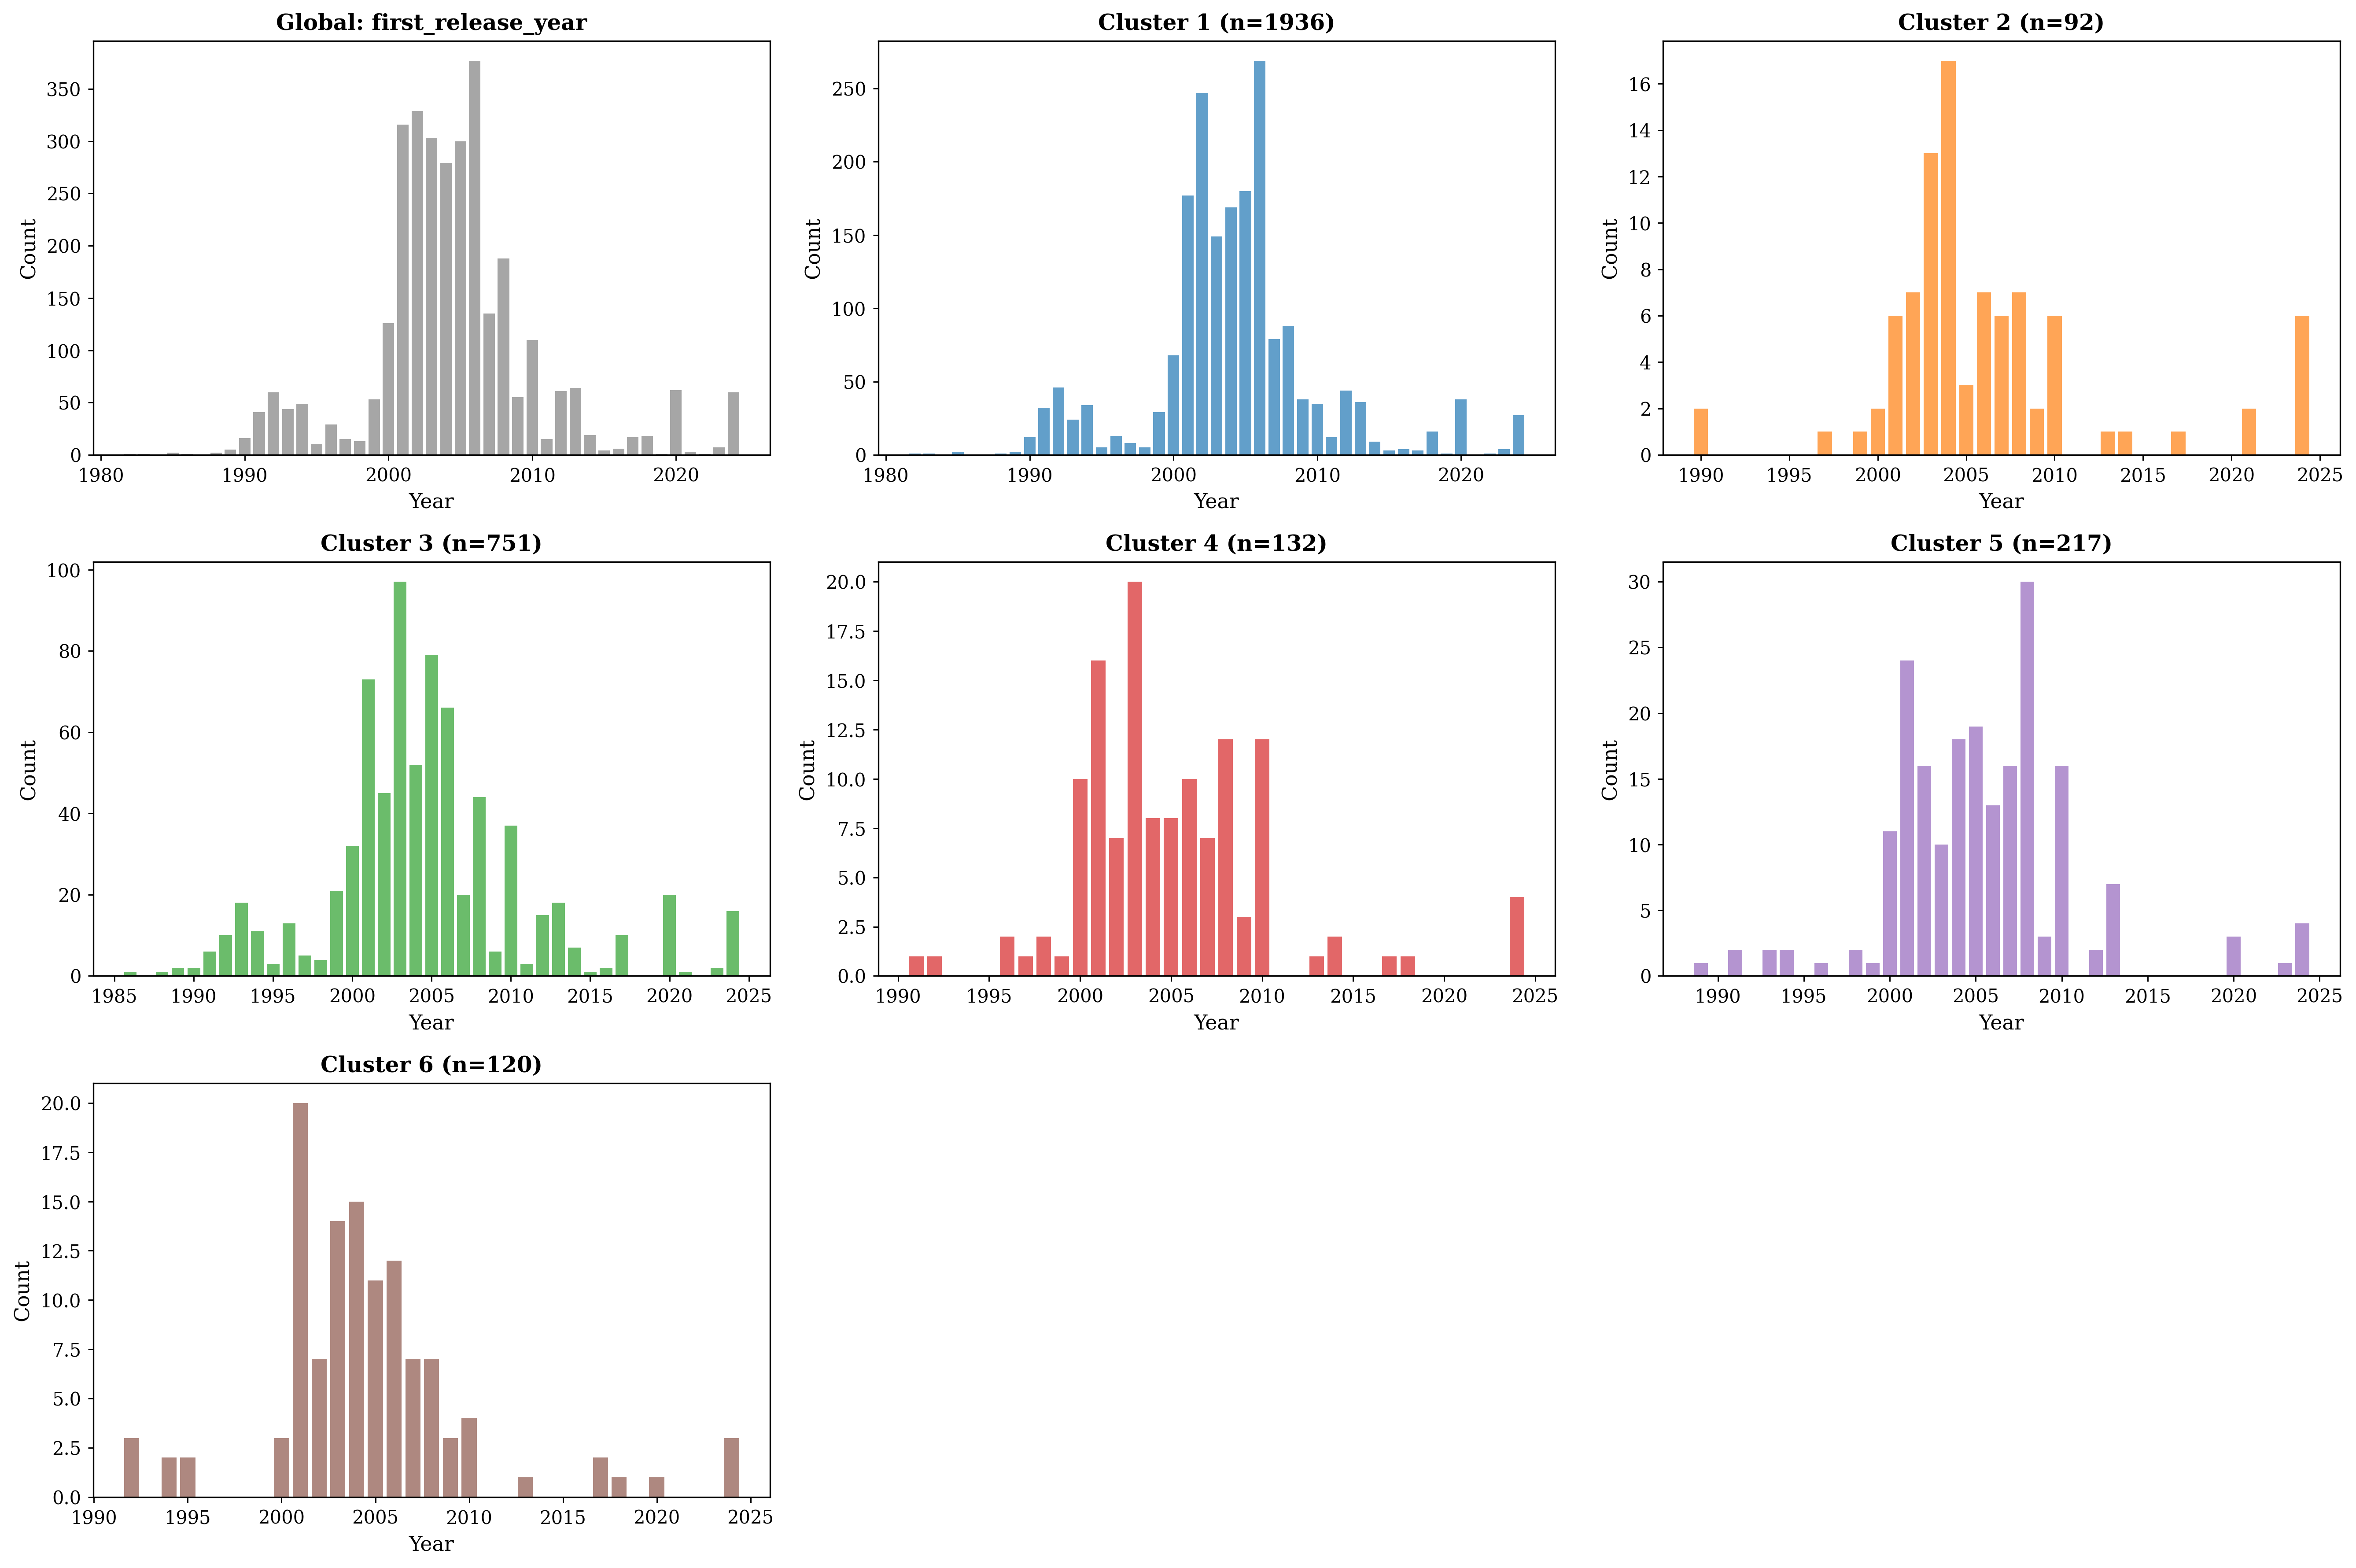


=== involved_companies ===
Figure saved to results/ctms_general/figs/ctms_involved_companies_distributions.png


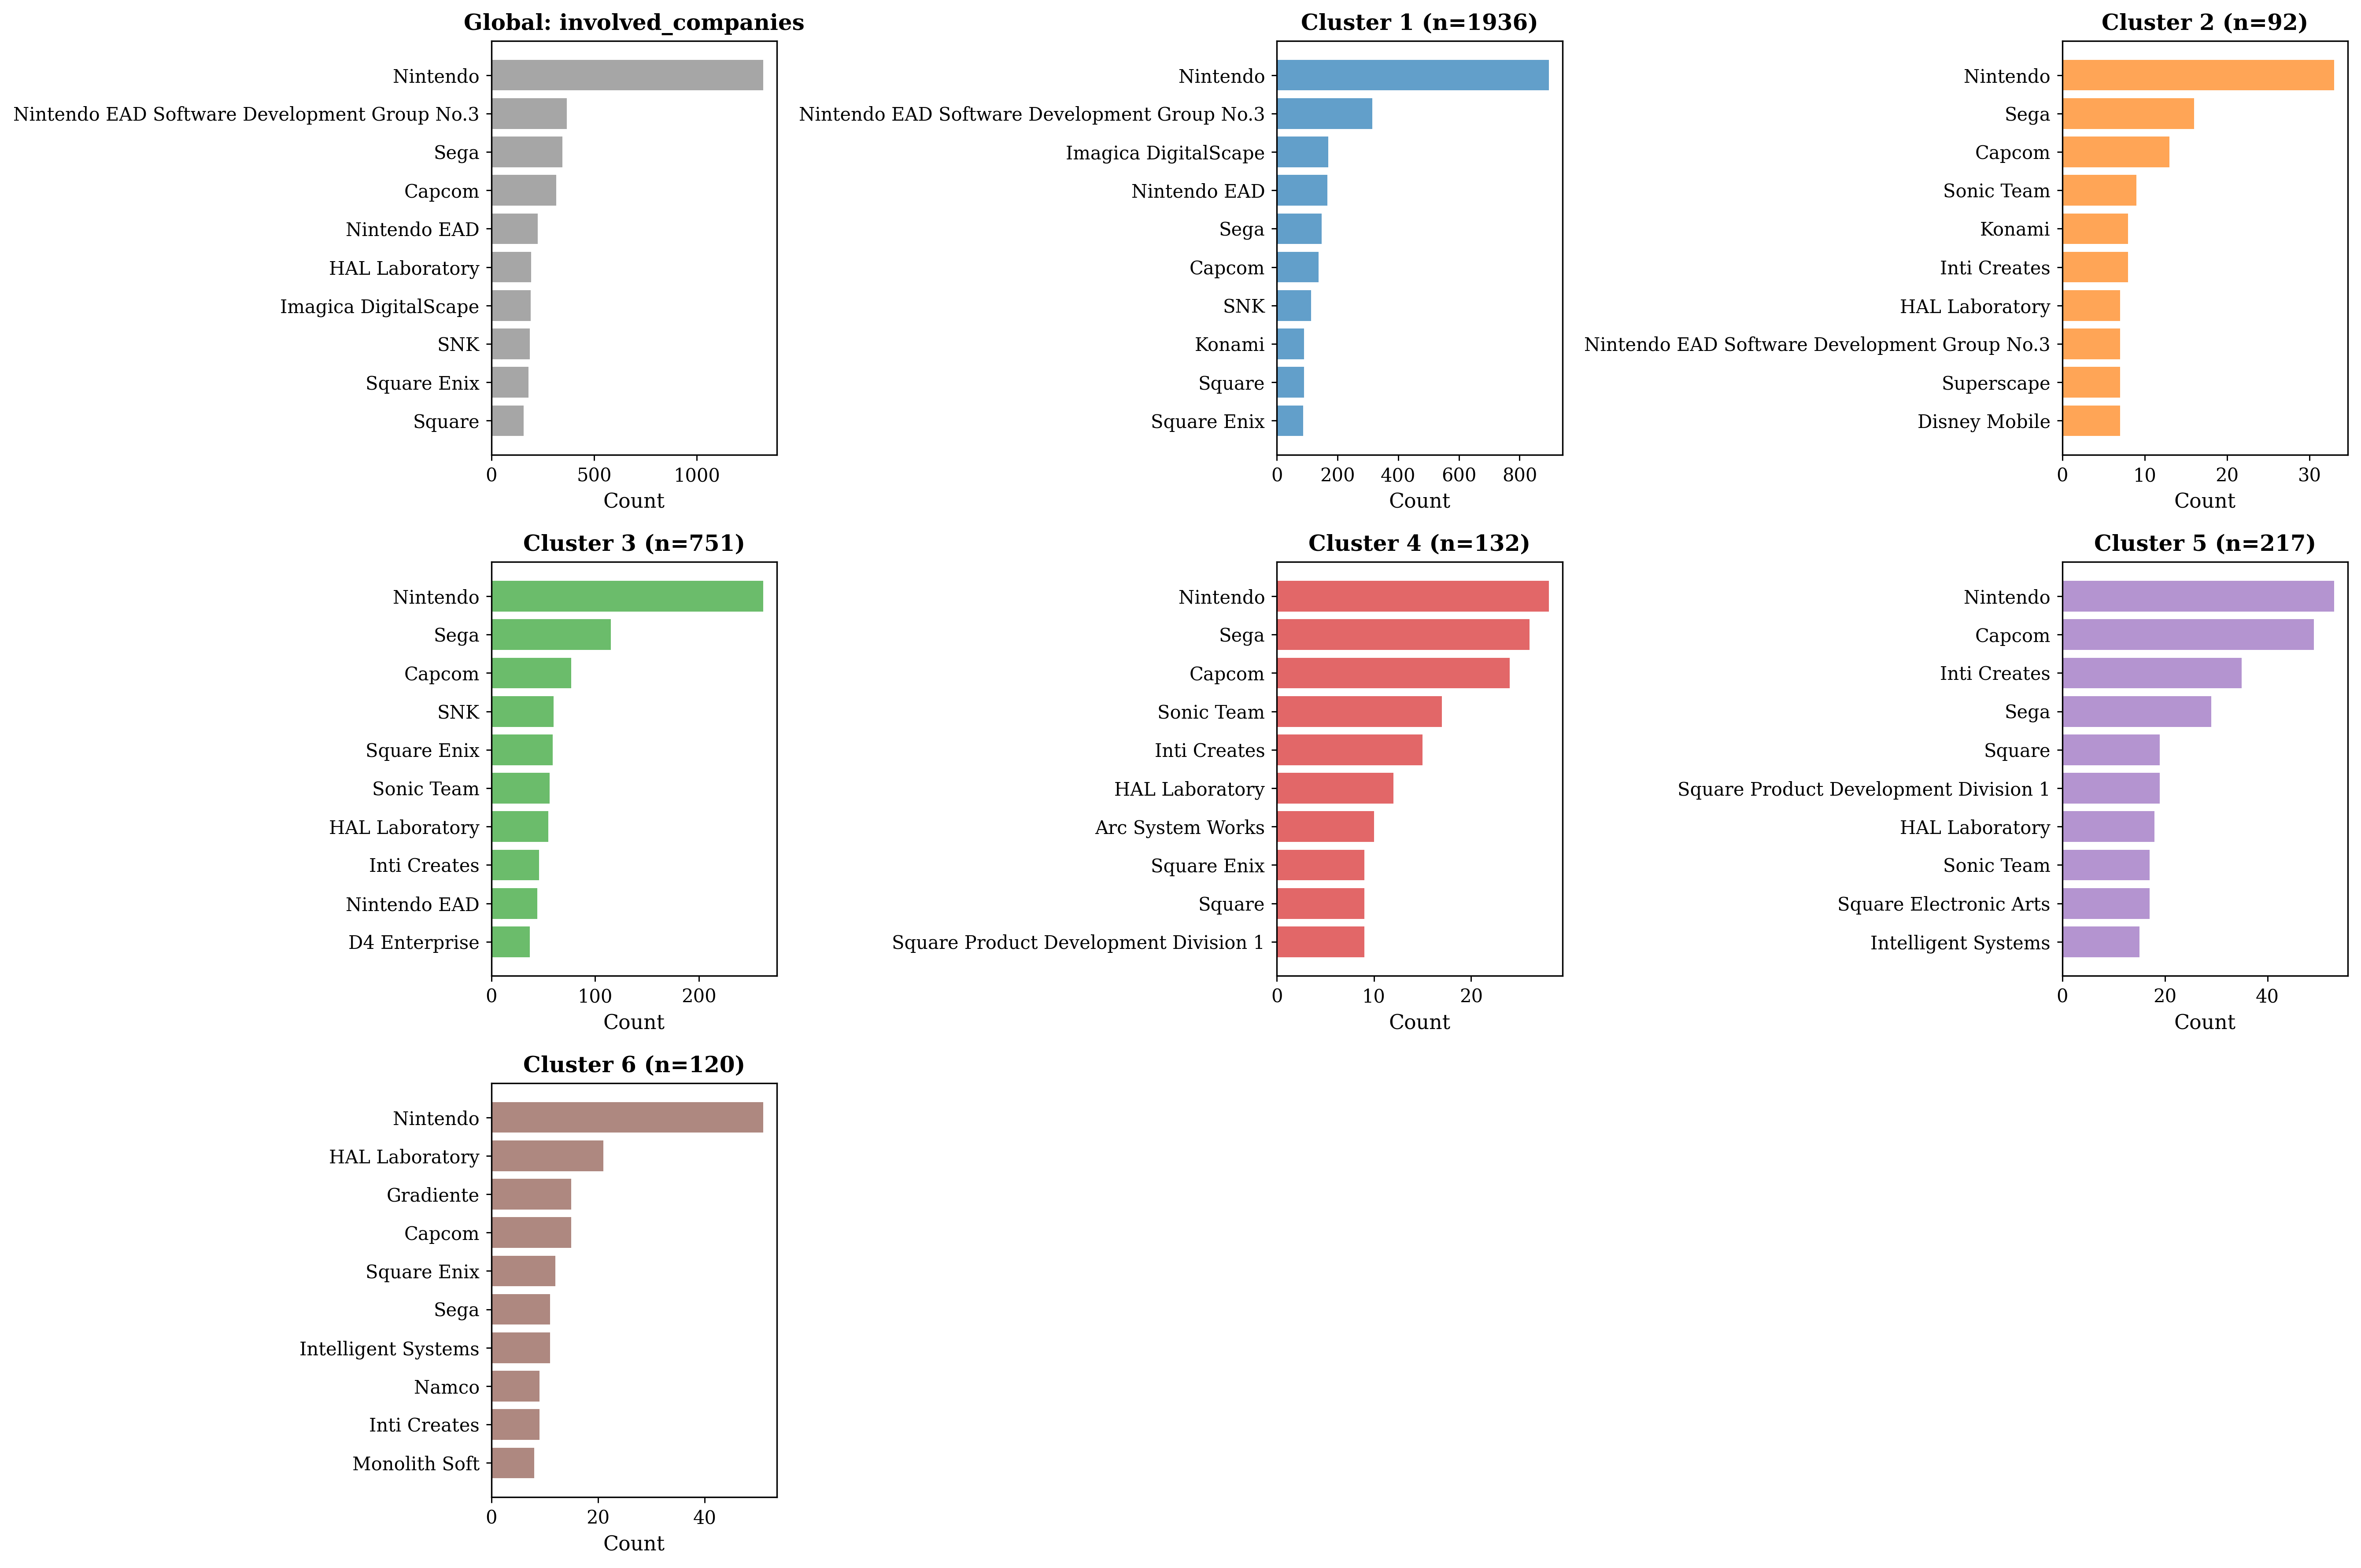


=== keywords ===
Figure saved to results/ctms_general/figs/ctms_keywords_distributions.png


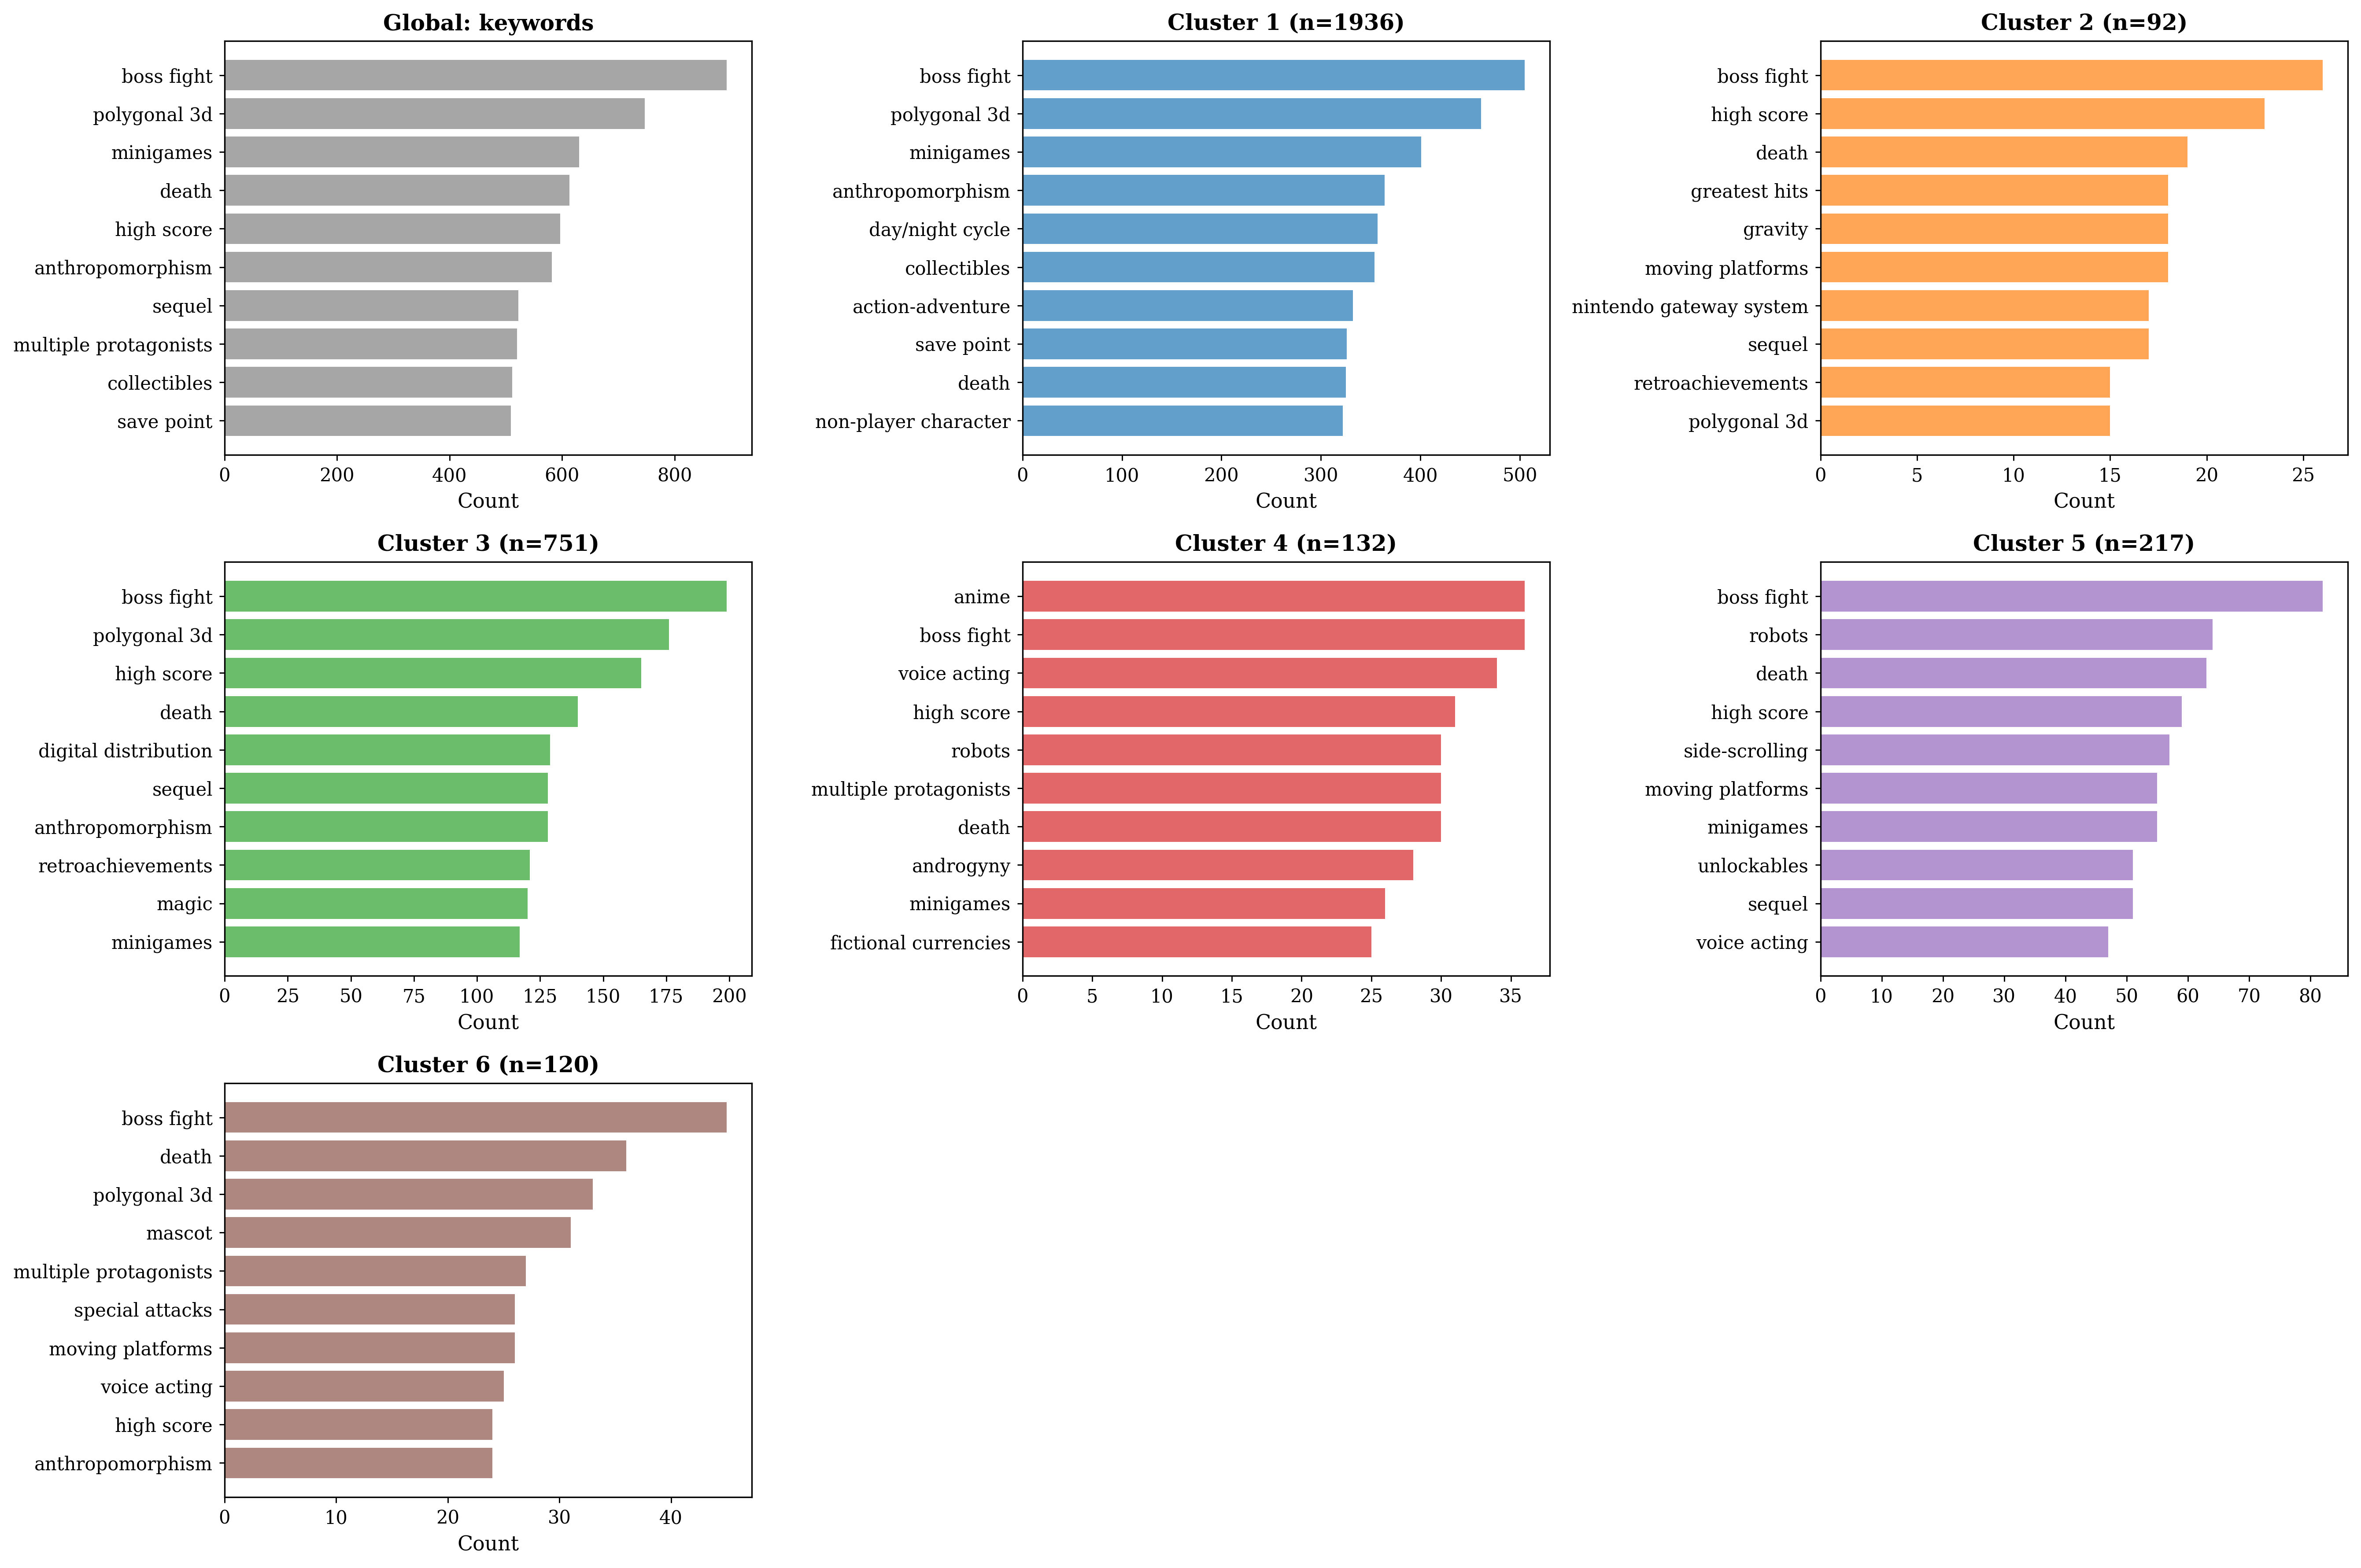


=== name ===
Figure saved to results/ctms_general/figs/ctms_name_distributions.png


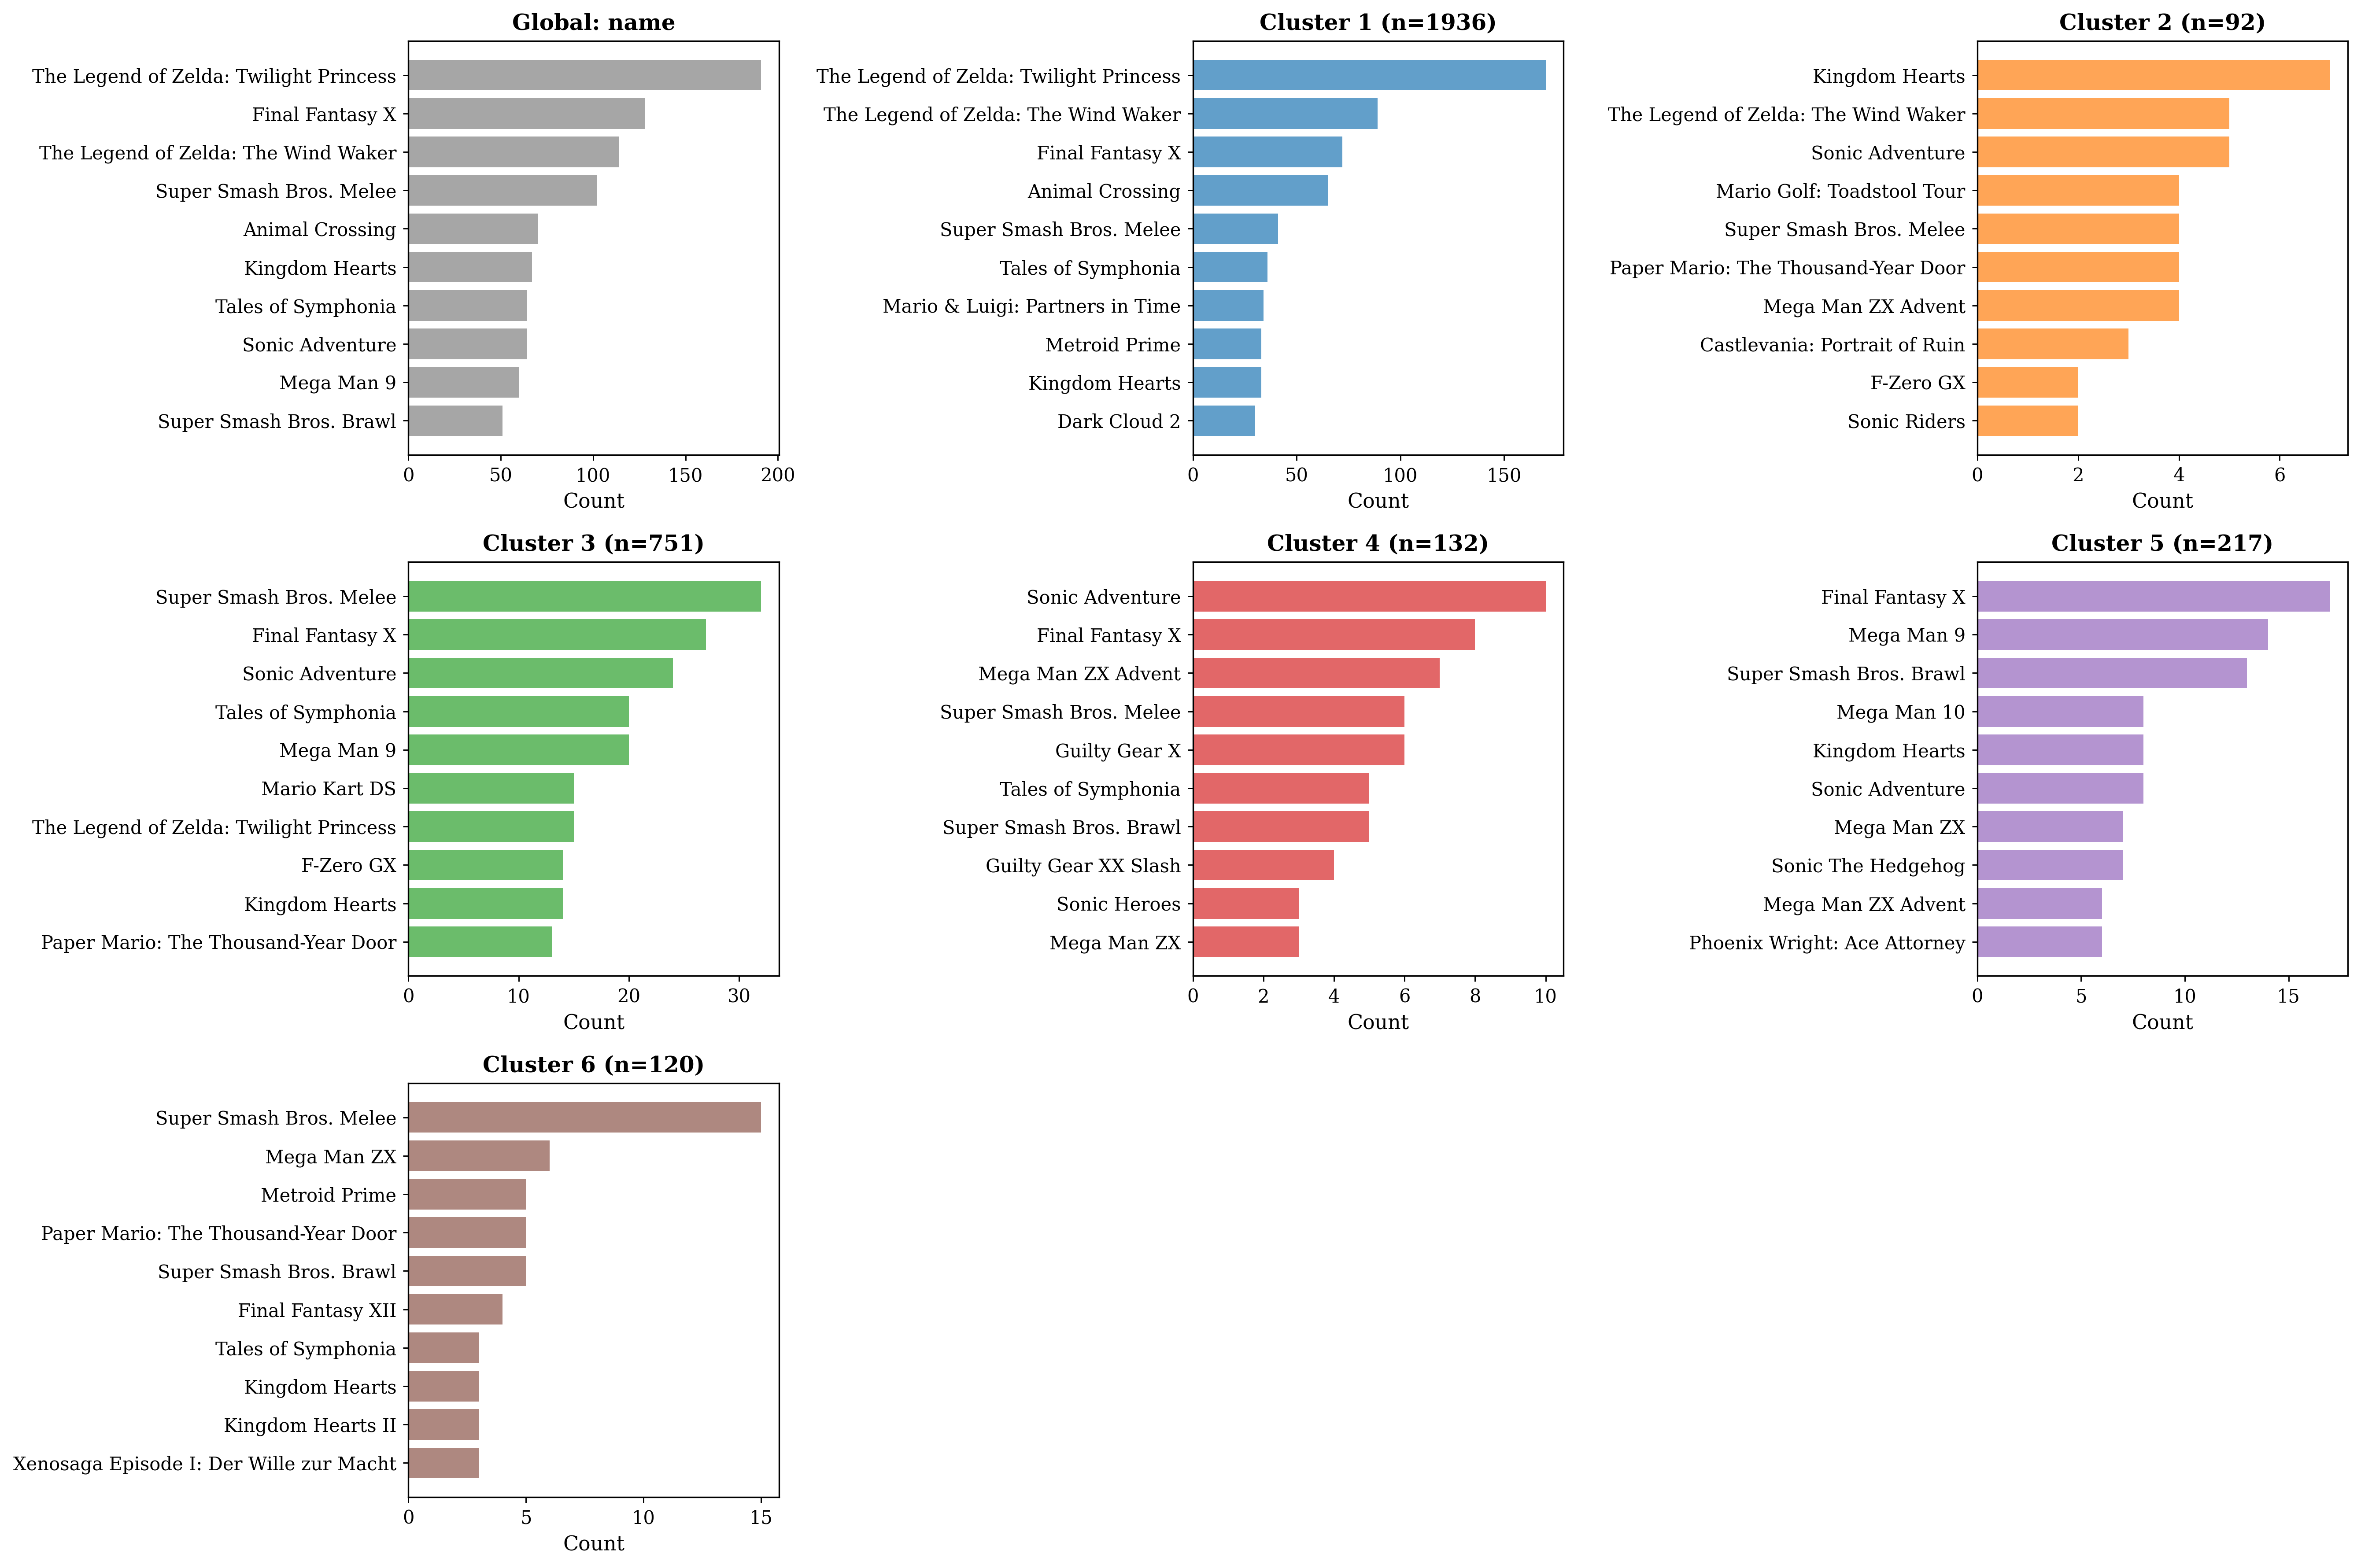


=== themes ===
Figure saved to results/ctms_general/figs/ctms_themes_distributions.png


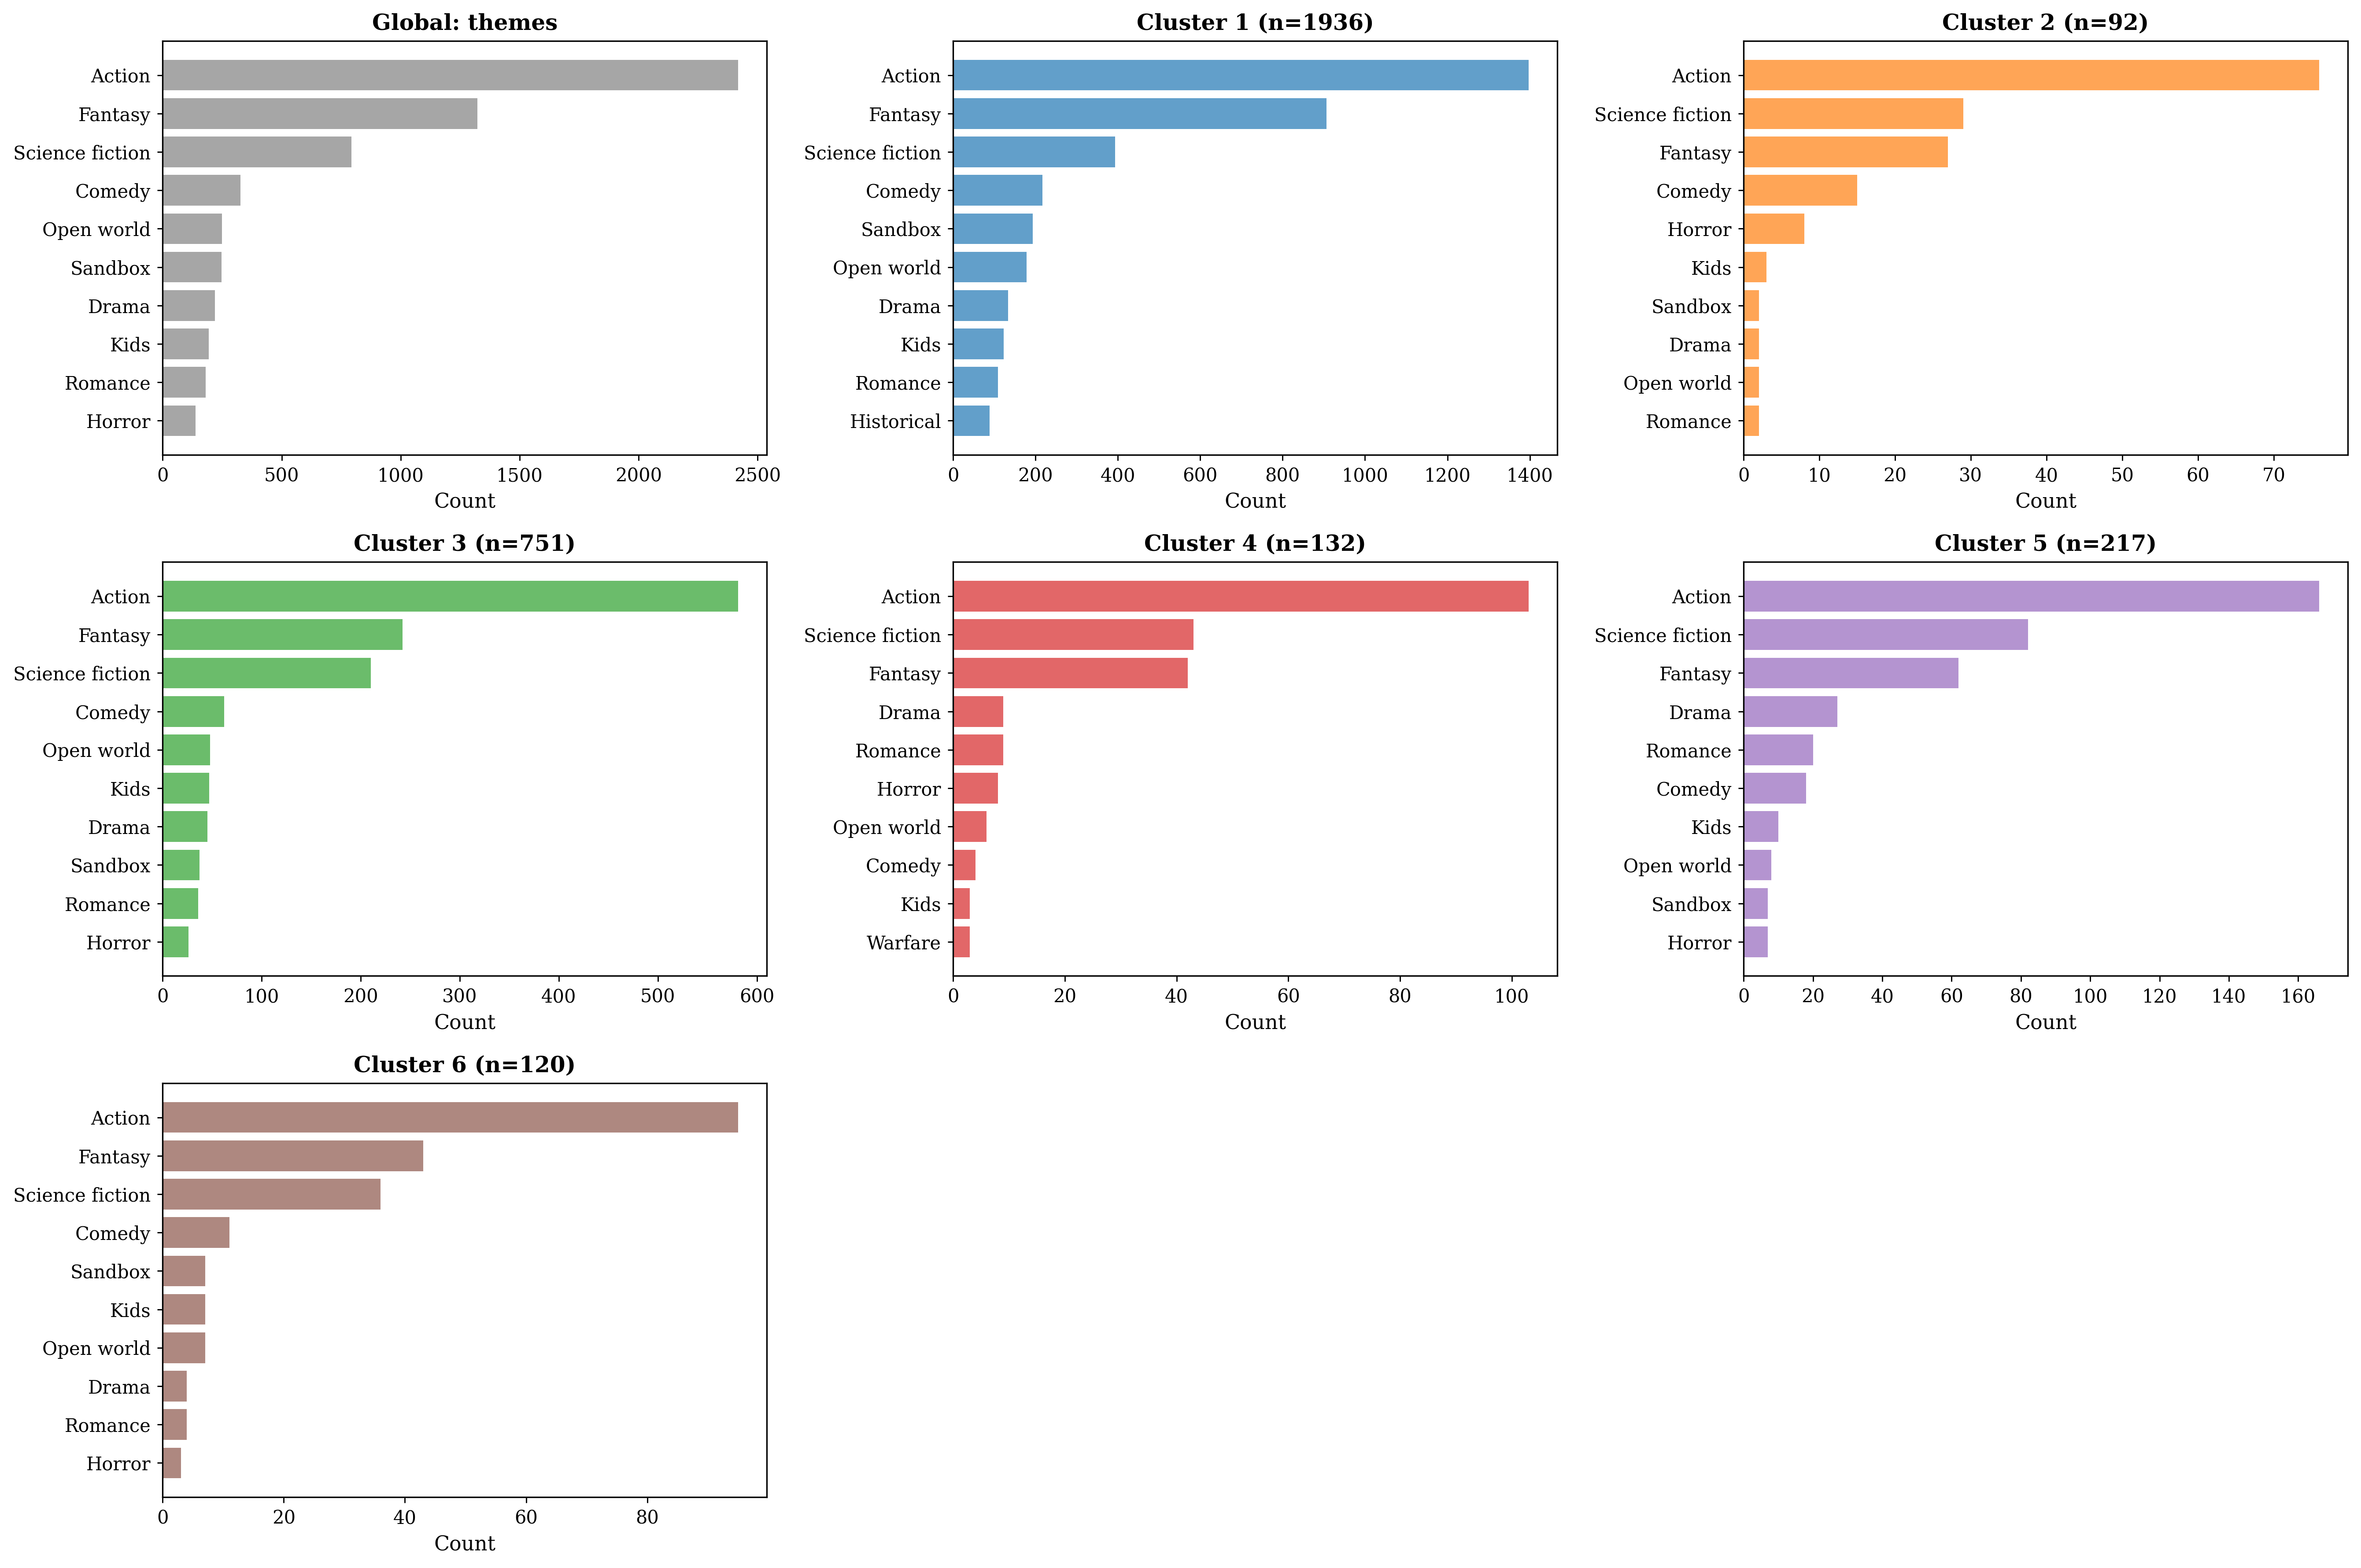


=== Cluster Sizes ===


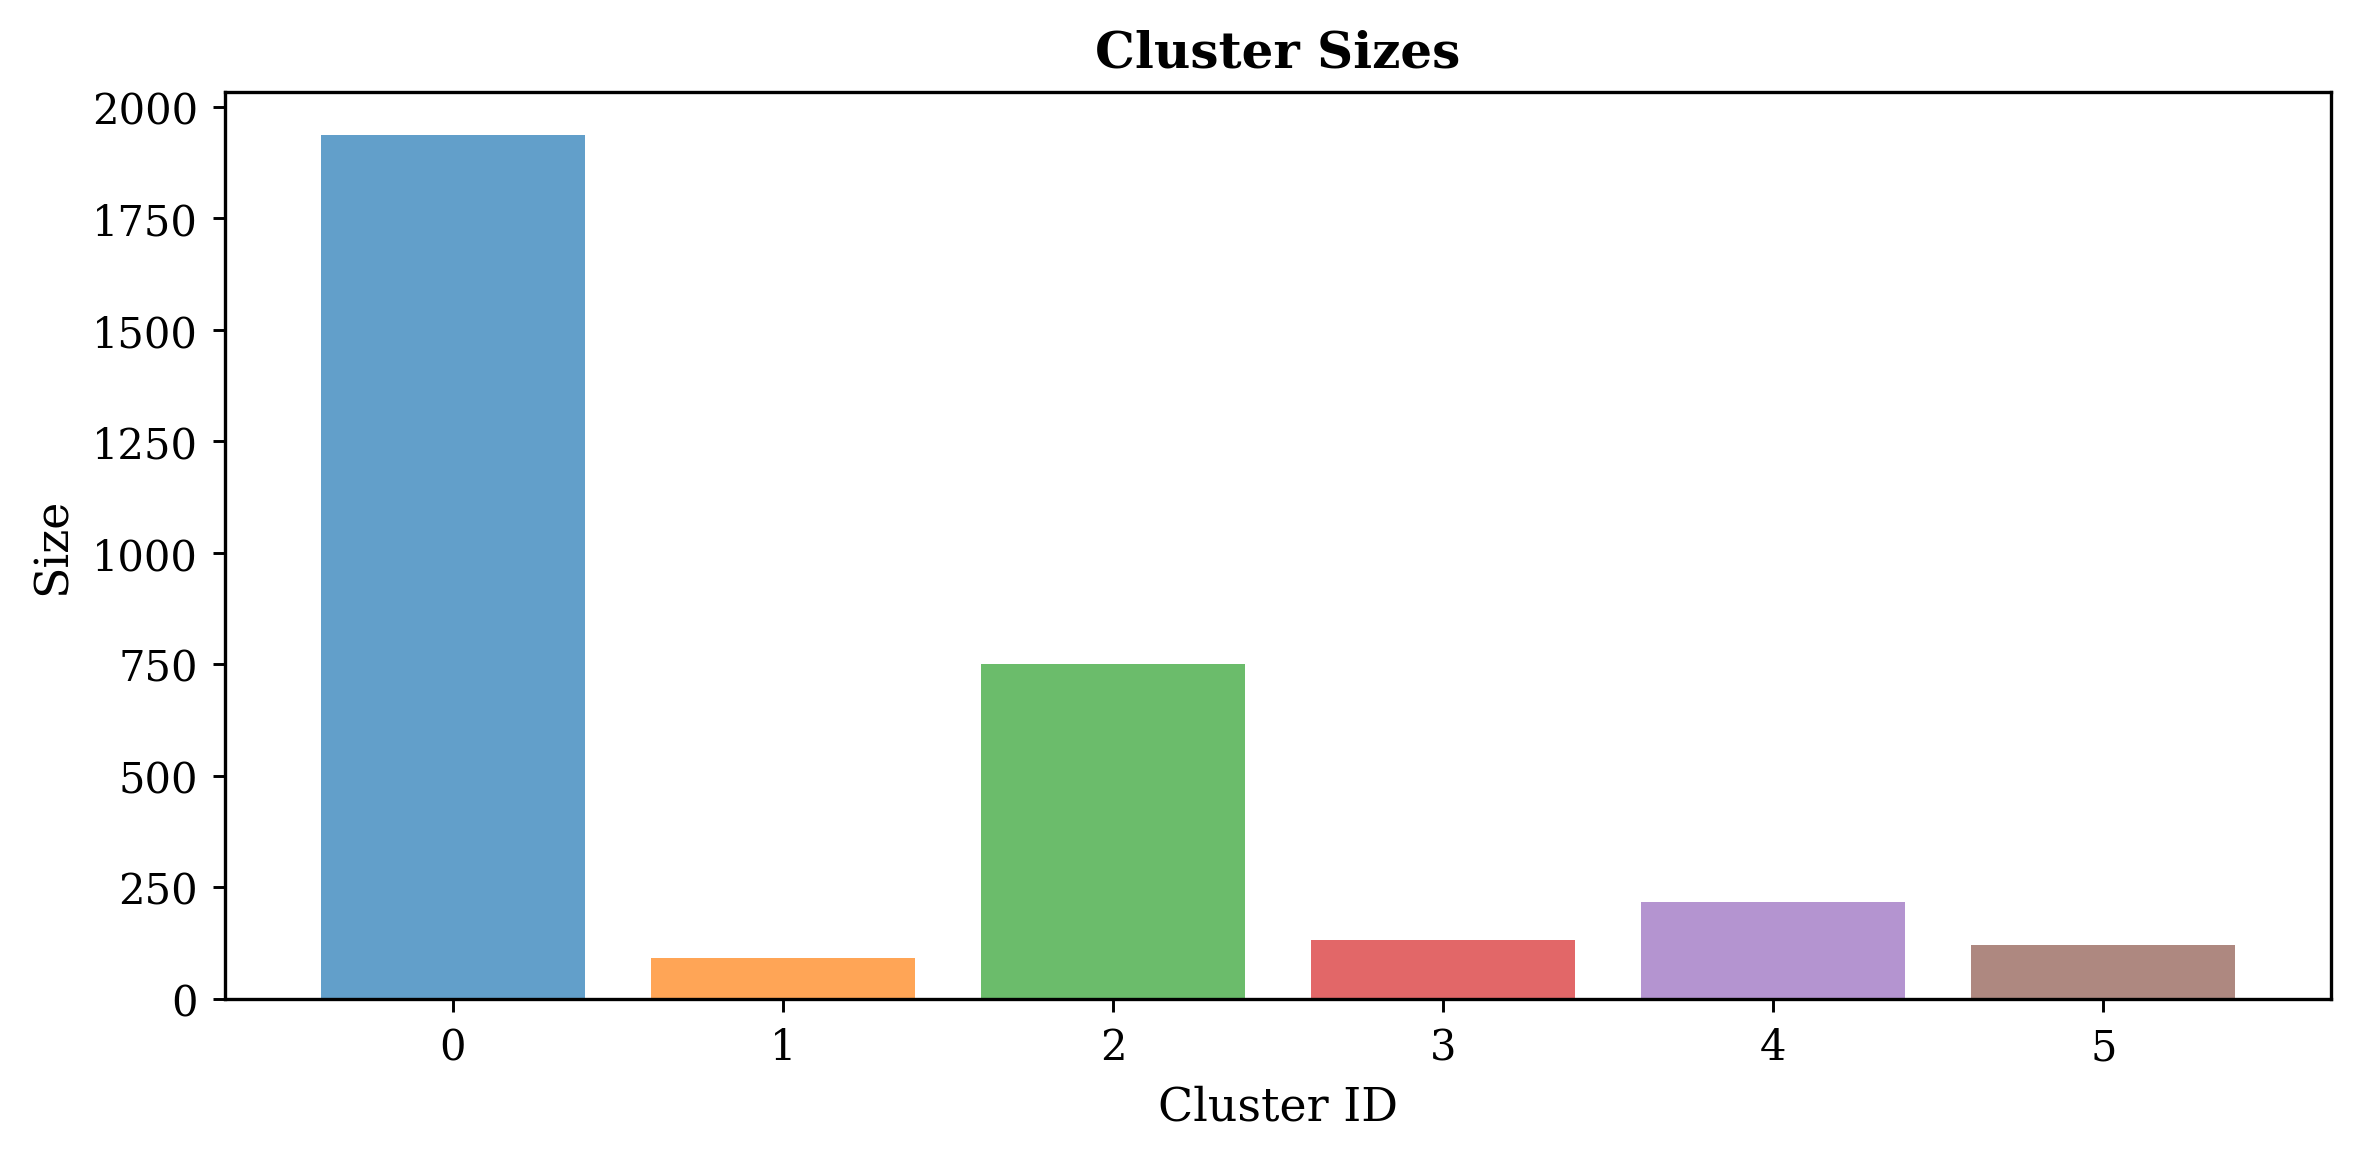

In [17]:
col_summary = {}
with open('results/ctms_general/json/ctms_column_summary.json', 'r') as f:
    col_summary = json.load(f)

plot_metadata_distributions(col_summary, top_n=10,save_dir=save_dir, model_name=model_name)